In [ ]:
# !pip yfinance -q

ERROR: unknown command "yfinance"


In [ ]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline


### **Stock Indicators**

In [436]:
def technical_indicators(df):
  df['Volume']=df['Volume']/1000000
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
    #SMA  #30days
  df['SMA10'] = df11['Close'].rolling(30).mean()
    #EMA
  df11['EWMA30'] = df11['Close'].ewm(span=10).mean()

  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))

   #stochastic oscillator
  df['14-high'] = df['High'].rolling(14).max()
  df['14-low'] = df['Low'].rolling(14).min()
  df['%K'] = (df['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
  df['%D'] = df['%K'].rolling(3).mean() 

  #MACD
  k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
  d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
  macd = k - d
  macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
  macd_h = macd - macd_s

  df['macd'] = df.index.map(macd)
  # df['macd_h'] = df.index.map(macd_h)
  # df['macd_s'] = df.index.map(macd_s)
  #   #A/D
  # df['cmfv'] = ((df['Close']-df['Low'])-(df['High']-df['Close']))/df['High']-df['Low']*df['Volume']
  # df['A/D'] = df['cmfv'].cumsum()/1000

    #OBV
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  #ROC
  N=df['Close'].diff(13)
  D=df['Close'].shift(13)
  df['ROC'] = pd.Series(100*N/D)

  #william R
  highh = df['High'].rolling(14).max() 
  lowl = df['Low'].rolling(14).min()
  df['wr'] = -100 * ((highh - df['Close']) / (highh - lowl))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 1000


  df11.drop(columns=['Close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat

dir=["JPM"]
dfs=[]
for i in range(len(dir)):
  Stock = pd.read_csv(dir[i]+".csv")
  USED_LENGTH=int(0.4*len(Stock))
  Stock = (Stock.iloc[USED_LENGTH:]).reset_index()    #only use generate prediction
  df=technical_indicators(Stock).drop(columns=['Date','Adj Close','index'])
  dfs.append(df)


print("Used length", USED_LENGTH)
assert(len(dfs)==len(dir))

FEATURE=dfs[0].shape[-1]
print(FEATURE)
print(dfs[0].columns)
dfs[0]


Used length 1341
18
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'SMA10', '14-high',
       '14-low', '%K', '%D', 'macd', 'obv', 'ROC', 'wr', 'disparity', 'EWMA30',
       'rsi'],
      dtype='object')


,Open,High,Low,Close,Volume,change,SMA10,14-high,14-low,%K,%D,macd,obv,ROC,wr,disparity,EWMA30,rsi
0,63.680000,64.870003,63.639999,64.720001,14.9725,-0.319999,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,0.0000,2.982078,-13.705577,16.614947,64.720001,66.294191
1,64.510002,65.320000,64.290001,64.400002,17.6924,-0.319999,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-17.6924,2.982078,-13.705577,16.614947,64.544002,66.294191
2,64.529999,65.070000,63.419998,63.919998,18.0879,-0.480004,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-35.7803,2.982078,-13.705577,16.614947,64.293156,66.294191
3,63.669998,64.599998,63.250000,64.500000,15.0399,0.580002,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-20.7404,2.982078,-13.705577,16.614947,64.361302,66.294191
4,64.970001,65.650002,64.599998,65.489998,16.8026,0.989998,66.271333,67.190002,63.250000,86.294423,76.988167,0.454400,-3.9378,2.982078,-13.705577,16.614947,64.685320,66.294191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,140.460007,141.100006,140.039993,140.729996,7.5675,0.190003,131.456666,141.779999,126.220001,93.251908,93.016259,2.287346,-512.8848,9.585733,-6.748092,47.621557,137.667015,66.196089
2008,139.600006,139.960007,137.630005,137.669998,10.6293,-3.059998,131.670666,141.779999,126.220001,73.586108,86.289608,2.178712,-523.5141,7.883392,-26.413892,19.826333,137.667557,57.013358
2009,137.619995,137.809998,134.000000,135.229996,14.4161,-2.440002,131.691000,141.779999,126.220001,57.904860,74.914292,1.874128,-537.9302,6.087703,-42.095140,-2.271394,137.224364,50.944705
2010,136.000000,137.910004,135.660004,137.050003,9.0411,1.820007,131.984000,141.779999,126.220001,69.601564,67.030844,1.759322,-528.8891,7.162408,-30.398436,6.077288,137.192662,54.808713


In [437]:
#Normalize time series
# Scalers = [ StandardScaler() for _ in range(len(dfs)) ]
dfs_standard=[]
for i in range(len(dfs)):
  dataset_standard = dfs[i]#Scalers[i].fit_transform(dfs[i])
  dfs_standard.append(dataset_standard)

print(dfs_standard[0].shape)

(2012, 18)


<ipython-input-438-8b6e80b885b3>:4: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)


Text(0, 80, 'JPM')

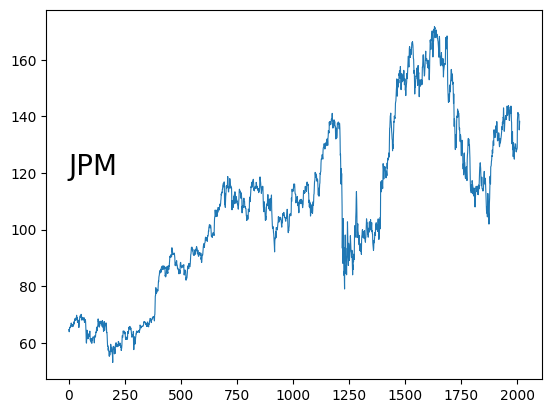

In [438]:
stock_price_array=np.array(dfs_standard[0])[:,3]   #Price   3
plt.plot(stock_price_array, linewidth=0.8)

plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)

In [439]:
stock_price_array=np.array(dfs_standard[0])[:,3]
stock_array=np.array(dfs_standard[0])
print(stock_array.shape)

(2012, 18)


### **Train Test Split**

1307
X_train length 1307
X_test length 705


<ipython-input-476-09be09bfe4de>:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)


Text(0, 80, 'JPM')

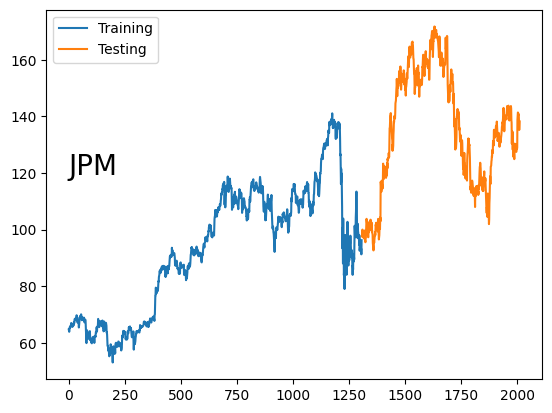

In [476]:
used_length=int(len(stock_array)*0.65)

stock_price_train=stock_price_array[:used_length]

stock_train=stock_array.copy()[:used_length]

stock_price_test=stock_price_array[used_length:]
stock_test=stock_array[used_length:]

print(used_length)

print("X_train length", len(stock_train))
print("X_test length", len(stock_test))

plt.plot(stock_price_train,label='Training')
plt.plot(np.arange(len(stock_price_train),len(stock_array)),stock_price_test, label='Testing')
plt.legend()
plt.annotate("JPM",xy=(0,80),textcoords='offset points', fontsize=20)

### **Stock Delta**

In [477]:
stock_delta_train= np.diff(stock_price_train, n=1, append=stock_price_train[-1])
stock_delta_test= np.diff(stock_price_test, n=1, append=stock_price_train[-1])
print(stock_price_train)
stock_delta_train


[64.720001 64.400002 63.919998 ... 93.300003 91.279999 96.269997]


array([-0.319999, -0.480004,  0.580002, ..., -2.020004,  4.989998,
        0.      ])

### **Use Transformer Generated Prediction**

In [478]:
stock_train.shape

(1307, 18)

In [479]:
transformer_pred = np.array(pd.read_csv("JPM_Pred.csv"))[USED_LENGTH:, 1:]
print(transformer_pred.shape)
transformer_pred_train=transformer_pred[:used_length]
transformer_pred_test=transformer_pred[used_length:]

print("pred train len",transformer_pred_train.shape)
print("pred test len",transformer_pred_test.shape)

(2012, 7)
pred train len (1307, 7)
pred test len (705, 7)


In [480]:
pred_delta_train= np.diff(transformer_pred_train, n=1, append=transformer_pred_train[:,-1:])
pred_delta_test= np.diff(transformer_pred_test, n=1, append=transformer_pred_test[:,-1:])
print(transformer_pred_train)
print(transformer_pred_train.shape)
print(pred_delta_train.shape)
pred_delta_train


[[61.763775 61.804462 61.772667 ... 61.707977 61.61629  61.59091 ]
 [62.274536 62.21454  62.00877  ... 61.99668  61.96086  62.209698]
 [63.071022 62.76545  62.85564  ... 62.790283 63.058266 62.943954]
 ...
 [93.9224   95.42417  95.94953  ... 96.52806  96.826515 96.2763  ]
 [95.30153  95.63262  96.02139  ... 96.432106 95.80766  96.23775 ]
 [96.04523  96.54553  96.7242   ... 96.19799  96.62367  96.17693 ]]
(1307, 7)
(1307, 7)


array([[ 0.040687, -0.031795, -0.127712, ..., -0.091687, -0.02538 ,
         0.      ],
       [-0.059996, -0.20577 ,  0.05374 , ..., -0.03582 ,  0.248838,
         0.      ],
       [-0.305572,  0.09019 , -0.001773, ...,  0.267983, -0.114312,
         0.      ],
       ...,
       [ 1.50177 ,  0.52536 ,  0.42406 , ...,  0.298455, -0.550215,
         0.      ],
       [ 0.33109 ,  0.38877 ,  0.209216, ..., -0.624446,  0.43009 ,
         0.      ],
       [ 0.5003  ,  0.17867 ,  0.223226, ...,  0.42568 , -0.44674 ,
         0.      ]])

### **Visualize Actual & Prediction & Trading Signals**

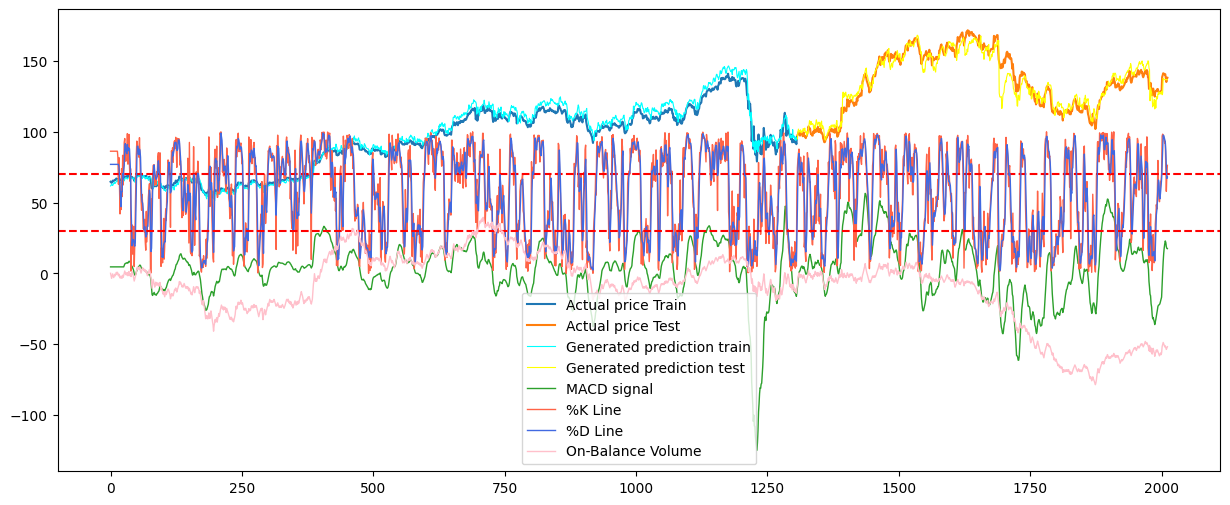

In [481]:
plt.figure(figsize=(15,6))
plt.plot(stock_price_train,label='Actual price Train')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),stock_price_test,label='Actual price Test')
plt.plot(transformer_pred_train[:,0], label='Generated prediction train',linewidth=0.8, color='cyan')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),transformer_pred_test[:,0], label='Generated prediction test',linewidth=0.8, color='yellow')

#MACD  
plt.plot(stock_array[:,11]*10, label="MACD signal",linewidth=1)

#Stochastic Oscillator
plt.plot(stock_array[:,9], label="%K Line",linewidth=1, color='tomato')
plt.axhline(y = 70, color = 'r', linestyle = '--')
plt.plot(stock_array[:,10], label="%D Line",linewidth=1, color='royalblue')
plt.axhline(y = 30, color = 'r', linestyle = '--')
# Bullish Signal: When the %K line crosses above the %D line and both lines are in the oversold region (below 20), 
# it indicates a potential buying opportunity. It suggests that positive momentum is increasing, and the price may start to rise.
# Bearish Signal: When the %K line crosses below the %D line and both lines are in the overbought region (above 80), 
# it indicates a potential selling opportunity. It suggests that negative momentum is increasing, and the price may start to decline.

plt.plot(stock_array[:,12]/10, label="On-Balance Volume",linewidth=1, color='pink')
#Bullish Signal: When the OBV line starts rising, it suggests that buying volume is increasing, indicating potential upward price movement. This is considered a bullish signal, indicating a potential buying opportunity.
#Bearish Signal: When the OBV line starts declining, it suggests that selling volume is increasing, indicating potential downward price movement. This is considered a bearish signal, indicating a potential selling opportunity.

plt.legend()

In [482]:
stock_price_train.max()

141.089996

In [483]:
transformer_pred[0]   #each day we have a window of prediction of next 7 days

array([61.763775, 61.804462, 61.772667, 61.644955, 61.707977, 61.61629 ,
       61.59091 ])

### **Create Trading Game**

In [619]:
TRANSACTION=0.0001
CONTEXT=10
LOOK_FORWARD=3
class Game:  # Create tradin game step day by day through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT, stock=stock_train, stock_price=stock_price_train, 
                 stock_delta=stock_delta_train, stock_pred_price=transformer_pred_train, pred_delta=pred_delta_train):
        self.w = w #window size
        self.stock=stock
        self.stock_price=stock_price
        self.stock_pred_price=stock_pred_price
        self.stock_delta=stock_delta_train
        self.pred_delta=pred_delta_train
        self.reset() 


    def reset(self):
        # restart game, initialize game state
        self.money=100000     #Initial Money
        self.positions=10000   #Initial Shares holding

        self.today=CONTEXT-LOOK_FORWARD-1      #30- 7-1   =22           past:0~22,      today:22 ,     future:23~29 
        self.inital_property=self.positions*self.stock_price[self.today]+self.money  #initial total investment = 10,000 shares + cash

        
        self.window_right=self.w-1   #29
        self.window_left=0         
        
        self.today_price = self.stock_price[self.today]        
        self.window = self.stock_price[ self.window_left:self.today+1] #price    0~14

        self.window_all=self.stock[ self.window_left:self.today+1]  #22 features
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property= self.inital_property
        self.profit=0 
        
        
        self.money_record=[self.money]*CONTEXT
        self.positions_record=[self.positions]*CONTEXT
        self.actions_record=[0]*CONTEXT

        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]
        self.actions_window=self.actions_record[self.window_left:self.today+1]

        self.window_pred=self.stock_pred_price[self.today,:LOOK_FORWARD]   # transformer predictions


        self.window_delta_past=self.stock_delta[self.window_left:self.today+1]
        self.window_delta_pred=self.pred_delta[self.today,:LOOK_FORWARD]

    def play_step(self, action):
        self.yesterday_price=self.money
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.money=self.money - self.today_price * action
         #update positions
        self.positions += action     #shares in hand

        self.money_record.append(self.money)
        self.positions_record.append(self.positions)
        self.actions_record.append(action)

        self.today += 1  # update the head and window
        self.today_price=self.stock_price[self.today] 
        #Move window forward
        self.window_left += 1 
        self.window_right += 1 

        self.window=self.stock_price[self.window_left:self.today+1]       # past prices 

        self.window_all=self.stock[self.window_left:self.today+1]         # past indicators

        self.window_pred=self.stock_pred_price[self.today+1,:LOOK_FORWARD]              # predicted price

        self.window_delta_past=self.stock_delta[self.window_left:self.today+1] #past delta
        self.window_delta_pred=self.pred_delta[self.today,:LOOK_FORWARD]                #predicted delta

        self.money_window=self.money_record[self.window_left:self.today+1]# past money recode
        self.positions_window=self.positions_record[self.window_left:self.today+1]#past position record
        self.actions_window=self.actions_record[self.window_left:self.today+1]

        
        reward=0
                #The reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.
        #TODO: Carefully DESIGN it, to help agent mimick experts' trading strategy first before letting it go

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property            -  abs(action)*TRANSACTION
        reward += 1*(self.window_pred.mean()- self.window_pred[0]) * action 
        reward = reward+ 10*(self.window_delta_pred.mean() - self.window_delta_past[-3:].mean()) * action
        reward += 0.2*( -100*self.window_all[-1,11] ) * action #MACD

        reward += 100.*( self.window_all[-1,9]> self.window_all[-1,10])* (action>0) * (self.window_all[-1,9]<30)*(self.window_all[-1,10]<30)
        reward += 100.*( self.window_all[-1,9]< self.window_all[-1,10])* (action<0) * (self.window_all[-1,9]>70)*(self.window_all[-1,10]>70)

#curriculum1: if future > today, and you buy today, then reward the agent, vice versa for sell
#curriculum2: if future delta > past delta, buy today get reward 
#curriculum3: if MACD(11) drop too low and perform bottom fishing buy, then reward 
#             if MACD too high and sell at peek, then reward
#curriculum 4:
# Bullish Signal: When the %K line(9) crosses above the %D(10) line and both lines are in the oversold region (below 20), 
# it indicates a potential buying opportunity. It suggests that positive momentum is increasing, and the price may start to rise.
# Bearish Signal: When the %K line crosses below the %D line and both lines are in the overbought region (above 80), 
# it indicates a potential selling opportunity. It suggests that negative momentum is increasing, and the price may start to decline.
        # 3. check if game over
        game_over = False
        if self.is_collision():
            game_over = True
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            return reward, game_over

        return reward, game_over

    def is_collision(self):
        # hits boundary 
        if self.window_right>len(self.stock_price)-2:
            return 1
        return 0


In [620]:
stock_train.shape

(1307, 18)

### **Define State, Action Space**

In [621]:
STATE_SIZE=3+ stock_train.shape[-1] #Position and Money, Action(3) + Indicator's feature dimension(22)
print("State size:", STATE_SIZE)  
ACTION_SPACE=np.arange(-4000,4001,500).tolist()    #Actions
ACTION_SIZE=len(ACTION_SPACE)
print("Action_size:", ACTION_SIZE)
print("Action_space:", ACTION_SPACE)

State size: 21
Action_size: 17
Action_space: [-4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]


### **Build Double Q leaning**

In [622]:
MAX_MEMORY = 20000 # record 20000 experiences, carefully tune this
BATCH_SIZE = 1024
criterion = nn.SmoothL1Loss()
LR = 0.001
GAMMA=0.995
TAU=0.8
Q_UPDATE_FREQ=5
#Qnet for a given state action pair gives value
class QNetwork(nn.Module):
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=128):
        super(QNetwork, self).__init__()
        # CNN scans for features : State embedding
        self.embedding=nn.Sequential(
        nn.Conv1d(state_size, hidden_size, kernel_size=7, stride=1, padding=3, bias=False ),
        # nn.LayerNorm([hidden_size, CONTEXT]),
        nn.GELU(),
        nn.BatchNorm1d(hidden_size),

        nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        # nn.LayerNorm([hidden_size, CONTEXT]),
        nn.BatchNorm1d(hidden_size),
        )

        self.blstm = torch.nn.LSTM(hidden_size, hidden_size, bias=True, batch_first=True, dropout=0.1, bidirectional=True)

        self.fc=nn.Sequential(
            
        nn.Linear(hidden_size*2, hidden_size*2),
        nn.GELU(),
        nn.Linear(hidden_size*2, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU()
        )
        self.Linear_out=nn.Linear(hidden_size * CONTEXT, action_size)
    def forward(self, x):
        # batch * time * feature --->  batch * feature * time for CNN       512, 256, 20
        out=self.embedding(torch.transpose(x,1,2)) 
        out=torch.transpose(out,1,2) # Permute back for Linear layers

        out,_ = self.blstm(out)
        out=self.fc(out)
        #predict Q values for each Action 
        out=self.Linear_out(    out.flatten(start_dim=1)   )
        return out

class DoubleDQN:
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256, lr=LR, tau=TAU,
                 q_update_freq=Q_UPDATE_FREQ, 
                 ):
        self.q_net = QNetwork(state_size, action_size, hidden_size).to(device)
        self.target_q_net = QNetwork(state_size, action_size, hidden_size).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.tau = tau
        self.total_steps=0
        self.q_update_freq=q_update_freq

    def soft_update(self):
        if self.total_steps % self.q_update_freq==0:
          for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()): #soft copy Q1's params over 
              target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)

    def train_step(self, state, action, reward, next_state, done):
      self.total_steps += 1

      states_tensor = torch.FloatTensor(state).to(device)  #batch_size * state_size 
      actions_tensor = torch.LongTensor(action).to(device)  #batch_size
      rewards_tensor = torch.FloatTensor(reward).to(device) #batch_size
      next_states_tensor = torch.FloatTensor(next_state).to(device)  #batch_size * state_size 
      dones_tensor = torch.BoolTensor(done).to(device)  #batch_size

      with torch.no_grad():
        q_next=self.target_q_net(next_states_tensor) #use 2-Qnet to estimate target Q      #batch_size * action_size
        max_q_next,_ = torch.max(q_next, dim=1)     #bach_size
        q_target = rewards_tensor + GAMMA * max_q_next * (~dones_tensor)   # Bellman Equation    batch_size

      q_pred = self.q_net(states_tensor)    #use 1-Qnet to get current Q rped     #batch_size * action)size
      actions_index=[]
      for b in range(BATCH_SIZE):
        actions_index.append(ACTION_SPACE.index(actions_tensor[b]))     
      actions_index=torch.LongTensor(actions_index).to(device)    #convert action played to action index for DQN
      #get Q value corresponds to the action played
      q_values_pred_selected = q_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)    #batch_size * action_size

      loss = criterion(q_values_pred_selected, q_target) /(BATCH_SIZE)      #Temporal Difference   

      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1e+8)
      self.optimizer.step()

      self.soft_update()  #soft update Double Q

      return loss.item()

### **Create Agent that play the game and sample experiences to train**

In [623]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.trainer = DoubleDQN()
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 


    def get_state(self, game):

        window_all=np.array(game.window_all )
        money_window=(np.array(game.money_window)/10000).reshape(-1,1)   #your money
        positions_window=(np.array(game.positions_window)/100).reshape(-1,1)
        actions_window=(np.array(game.actions_window)/100).reshape(-1,1)

        
        pred_window = np.array(game.window_pred ).reshape(-1,1)

        assert(game.money>=0.0)     #make sure money doesn't got to negative
        assert(game.positions>=0.0) #make sure positions doesn't go to negative

        state= np.concatenate( [positions_window, money_window, actions_window, window_all], axis=-1  ) # 23, 24    #Concate Feature with Pos+Money

        pred_window_repeat=np.repeat(pred_window, state.shape[-1], axis=-1)   #7, 24   #Prediction broadcasting

        state=np.concatenate([state, pred_window_repeat], axis=0)   #30, 24     #Concate Past + Future
        # print(state.shape)
        return state

    def remember(self, state, action, reward, next_state, done):
        # state=(state- np.mean(state,axis=0))/np.std(state,axis=0) #normalize
        reward/=100
        self.memory.append((state, action, reward, next_state, done)) # Deque popleft if MAX_MEMORY is reached


    def train_batch_experience(self):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
        return 0.
    def train_short_experience(self, batch_size=32):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, batch_size)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
        return 0.
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 80 - self.n_games//6   #6 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<10:
          self.epsilon=10 #not allowing below 10%  randomness
        position=game.positions
        money=game.money

        today_price=game.today_price

        final_move=0.
        #Explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price >= money:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a*today_price < money:
                  return a
              
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a
#===================================================================================================================================
        #Take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)  #observe
            Q_pred= self.trainer.q_net(state_input)    #USE QNet to get actions' value
            move = torch.argmax(Q_pred).item()         #Find best action index
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]   #Map Argmax index to action
        #Clip Action!! 
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price > money:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a*today_price< money: #find action that doesn't use up all your money in action space
                  # print("action", a, today_price, money)
                  return a
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        if final_move>0 and final_move*today_price >= money:    
          return 0.
        if final_move<0 and final_move<-position:
          return 0.
        return final_move

actions=[]
plot_profit=[]
plot_reward=[]
plot_loss=[]
agent = Agent()  #create agent 
def train():
    rewards = []
    record = 0
    #create game on Training set
    game = Game()
    epoch=500000 #a very large number just to keep the game running
    optimizer=agent.trainer.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price_train.shape[0]*3, gamma=0.995)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])  
        state_old = agent.get_state(game)            #observe 
        action = agent.get_action(state_old, game)   #action
        actions.append(action)
        reward, done= game.play_step(action)         #get reward
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)            #observe again
        # memory stored for replay
        agent.remember(state_old, action, reward, state_new, done)   #store Experience
        # loss=agent.train_short_experience(32)

        rewards.append(reward)     
        profit=game.profit    

        if done:
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            # for i in range(2):
            loss=agent.train_batch_experience()
            plot_loss.append(loss)
            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon,"lr",round(curr_lr,6), "loss", round(loss,6))

            plot_profit.append(profit)
        scheduler.step()


In [624]:
# from google.colab import drive
# drive.mount('/content/drive')

In [625]:
# PATH = "/content/drive/MyDrive/checkpoint01"
# torch.save(agent.trainer.q_net.state_dict(), PATH)

In [626]:
gc.collect()
torch.cuda.empty_cache()

### **Train and see Rewards and Profits**

In [627]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 1589/500000 [00:00<06:00, 1382.34it/s]

Game 1 mean Reward -612.89 Profit -4.96 Record: 0 eps 80 lr 0.001 loss 0.421443


  1%|          | 2979/500000 [00:02<07:33, 1095.74it/s]

Game 2 mean Reward 1231.11 Profit 10.81 Record: 10.81 eps 80 lr 0.001 loss 0.387474


  1%|          | 4116/500000 [00:03<10:48, 764.54it/s]

Game 3 mean Reward 846.21 Profit 13.41 Record: 13.41 eps 80 lr 0.001 loss 0.399097


  1%|          | 5474/500000 [00:04<11:25, 721.82it/s]

Game 4 mean Reward 1236.32 Profit -0.83 Record: 13.41 eps 80 lr 0.000995 loss 0.36164


  1%|▏         | 6762/500000 [00:05<08:36, 954.82it/s]

Game 5 mean Reward -47.22 Profit -3.78 Record: 13.41 eps 80 lr 0.000995 loss 0.344578


  2%|▏         | 8159/500000 [00:06<07:42, 1063.00it/s]

Game 6 mean Reward 274.41 Profit 12.07 Record: 13.41 eps 80 lr 0.000995 loss 0.397997


  2%|▏         | 9220/500000 [00:07<09:02, 904.93it/s]

Game 7 mean Reward 410.05 Profit 15.17 Record: 15.17 eps 79 lr 0.00099 loss 0.396855


  2%|▏         | 10634/500000 [00:09<08:12, 992.72it/s]

Game 8 mean Reward -217.5 Profit 12.41 Record: 15.17 eps 79 lr 0.00099 loss 0.369894


  2%|▏         | 11930/500000 [00:10<08:49, 921.14it/s]

Game 9 mean Reward 392.75 Profit 7.1 Record: 15.17 eps 79 lr 0.00099 loss 0.36093


  3%|▎         | 13296/500000 [00:11<08:10, 991.61it/s]

Game 10 mean Reward 53.06 Profit 0.18 Record: 15.17 eps 79 lr 0.000985 loss 0.355542


  3%|▎         | 14585/500000 [00:12<08:11, 986.73it/s]

Game 11 mean Reward -70.29 Profit 15.78 Record: 15.78 eps 79 lr 0.000985 loss 0.384608


  3%|▎         | 15908/500000 [00:13<08:19, 969.15it/s]

Game 12 mean Reward 634.51 Profit 16.39 Record: 16.39 eps 79 lr 0.000985 loss 0.360648


  3%|▎         | 17128/500000 [00:14<08:38, 930.69it/s]

Game 13 mean Reward -715.33 Profit -6.89 Record: 16.39 eps 78 lr 0.00098 loss 0.35743


  4%|▎         | 18381/500000 [00:16<14:18, 561.08it/s]

Game 14 mean Reward 265.84 Profit 10.35 Record: 16.39 eps 78 lr 0.00098 loss 0.312152


  4%|▍         | 19745/500000 [00:17<11:04, 722.36it/s]

Game 15 mean Reward -673.88 Profit -24.58 Record: 16.39 eps 78 lr 0.00098 loss 0.344351


  4%|▍         | 20963/500000 [00:18<08:57, 890.63it/s]

Game 16 mean Reward -1685.12 Profit -29.53 Record: 16.39 eps 78 lr 0.000975 loss 0.336173


  4%|▍         | 22363/500000 [00:19<08:48, 904.45it/s]

Game 17 mean Reward 1461.47 Profit 20.91 Record: 20.91 eps 78 lr 0.000975 loss 0.337994


  5%|▍         | 23514/500000 [00:21<08:59, 882.78it/s]

Game 18 mean Reward 291.93 Profit 3.01 Record: 20.91 eps 78 lr 0.000975 loss 0.3271


  5%|▍         | 24899/500000 [00:22<09:17, 852.46it/s]

Game 19 mean Reward 627.57 Profit -6.29 Record: 20.91 eps 77 lr 0.00097 loss 0.319279


  5%|▌         | 26099/500000 [00:23<08:43, 905.95it/s]

Game 20 mean Reward -713.34 Profit -7.35 Record: 20.91 eps 77 lr 0.00097 loss 0.342876


  5%|▌         | 27378/500000 [00:24<08:20, 943.78it/s]

Game 21 mean Reward -389.31 Profit 9.54 Record: 20.91 eps 77 lr 0.00097 loss 0.413261


  6%|▌         | 28732/500000 [00:25<08:18, 945.89it/s]

Game 22 mean Reward 876.03 Profit -18.14 Record: 20.91 eps 77 lr 0.000966 loss 0.392613


  6%|▌         | 30120/500000 [00:26<08:27, 925.06it/s]

Game 23 mean Reward -230.19 Profit 21.24 Record: 21.24 eps 77 lr 0.000966 loss 0.393095


  6%|▋         | 31325/500000 [00:28<10:53, 717.69it/s]

Game 24 mean Reward 180.66 Profit -0.04 Record: 21.24 eps 77 lr 0.000966 loss 0.336316


  7%|▋         | 32593/500000 [00:29<12:40, 614.21it/s]

Game 25 mean Reward 1019.52 Profit 24.94 Record: 24.94 eps 76 lr 0.000961 loss 0.368522


  7%|▋         | 33918/500000 [00:30<08:24, 924.74it/s]

Game 26 mean Reward -336.66 Profit 18.56 Record: 24.94 eps 76 lr 0.000961 loss 0.533024


  7%|▋         | 35229/500000 [00:31<08:09, 950.09it/s]

Game 27 mean Reward -19.99 Profit -4.56 Record: 24.94 eps 76 lr 0.000961 loss 0.470084


  7%|▋         | 36515/500000 [00:33<09:02, 854.19it/s]

Game 28 mean Reward -359.74 Profit -5.54 Record: 24.94 eps 76 lr 0.000956 loss 0.434839


  8%|▊         | 37865/500000 [00:34<08:18, 927.95it/s]

Game 29 mean Reward 231.61 Profit 1.98 Record: 24.94 eps 76 lr 0.000956 loss 0.428627


  8%|▊         | 39212/500000 [00:35<08:24, 912.51it/s]

Game 30 mean Reward 541.51 Profit 18.28 Record: 24.94 eps 76 lr 0.000956 loss 0.382536


  8%|▊         | 40541/500000 [00:36<08:11, 933.96it/s]

Game 31 mean Reward 126.7 Profit 49.53 Record: 49.53 eps 75 lr 0.000951 loss 0.611426


  8%|▊         | 41718/500000 [00:37<08:30, 897.10it/s]

Game 32 mean Reward 1050.86 Profit 2.19 Record: 49.53 eps 75 lr 0.000951 loss 0.550296


  9%|▊         | 43098/500000 [00:38<08:29, 896.15it/s]

Game 33 mean Reward -584.64 Profit -15.51 Record: 49.53 eps 75 lr 0.000951 loss 0.497766


  9%|▉         | 44288/500000 [00:40<10:49, 701.76it/s]

Game 34 mean Reward 359.24 Profit -14.49 Record: 49.53 eps 75 lr 0.000946 loss 0.423821


  9%|▉         | 45533/500000 [00:41<14:00, 540.42it/s]

Game 35 mean Reward 207.5 Profit 37.75 Record: 49.53 eps 75 lr 0.000946 loss 0.400846


  9%|▉         | 46862/500000 [00:43<08:25, 896.54it/s]

Game 36 mean Reward 1670.25 Profit 3.06 Record: 49.53 eps 75 lr 0.000946 loss 0.718558


 10%|▉         | 48236/500000 [00:44<08:47, 856.15it/s]

Game 37 mean Reward 841.12 Profit -7.98 Record: 49.53 eps 74 lr 0.000942 loss 0.577764


 10%|▉         | 49512/500000 [00:45<08:55, 841.20it/s]

Game 38 mean Reward -1055.1 Profit -2.71 Record: 49.53 eps 74 lr 0.000942 loss 0.515701


 10%|█         | 50775/500000 [00:46<09:07, 820.21it/s]

Game 39 mean Reward -605.18 Profit -1.59 Record: 49.53 eps 74 lr 0.000942 loss 0.558239


 10%|█         | 52027/500000 [00:47<10:48, 691.13it/s] 

Game 40 mean Reward -96.26 Profit 0.75 Record: 49.53 eps 74 lr 0.000937 loss 0.51314


 11%|█         | 53423/500000 [00:49<08:47, 847.07it/s]

Game 41 mean Reward -111.82 Profit 5.53 Record: 49.53 eps 74 lr 0.000937 loss 0.784004


 11%|█         | 54723/500000 [00:50<08:37, 860.01it/s]

Game 42 mean Reward 2287.39 Profit 53.18 Record: 53.18 eps 74 lr 0.000937 loss 0.728638


 11%|█         | 55990/500000 [00:51<08:51, 836.06it/s]

Game 43 mean Reward 847.34 Profit -1.87 Record: 53.18 eps 73 lr 0.000932 loss 0.635589


 11%|█▏        | 57227/500000 [00:53<13:14, 557.06it/s]

Game 44 mean Reward -1467.0 Profit -9.04 Record: 53.18 eps 73 lr 0.000932 loss 0.552284


 12%|█▏        | 58610/500000 [00:54<11:27, 641.77it/s]

Game 45 mean Reward -89.37 Profit 8.92 Record: 53.18 eps 73 lr 0.000932 loss 0.485421


 12%|█▏        | 59868/500000 [00:55<08:40, 845.14it/s]

Game 46 mean Reward 999.93 Profit 18.97 Record: 53.18 eps 73 lr 0.000928 loss 0.760511


 12%|█▏        | 61132/500000 [00:57<09:10, 797.90it/s]

Game 47 mean Reward -103.07 Profit 4.46 Record: 53.18 eps 73 lr 0.000928 loss 0.60983


 13%|█▎        | 62528/500000 [00:58<08:44, 834.12it/s]

Game 48 mean Reward 456.11 Profit 9.47 Record: 53.18 eps 73 lr 0.000928 loss 0.573279


 13%|█▎        | 63743/500000 [00:59<08:41, 836.48it/s]

Game 49 mean Reward 600.06 Profit 38.07 Record: 53.18 eps 72 lr 0.000923 loss 0.605712


 13%|█▎        | 65102/500000 [01:00<08:55, 812.02it/s]

Game 50 mean Reward 2164.26 Profit 2.91 Record: 53.18 eps 72 lr 0.000923 loss 0.54962


 13%|█▎        | 66336/500000 [01:02<08:32, 846.78it/s]

Game 51 mean Reward 562.28 Profit 24.57 Record: 53.18 eps 72 lr 0.000923 loss 0.776644


 14%|█▎        | 67695/500000 [01:03<08:46, 820.46it/s]

Game 52 mean Reward 971.59 Profit 0.95 Record: 53.18 eps 72 lr 0.000918 loss 0.714922


 14%|█▍        | 68878/500000 [01:04<10:25, 689.50it/s]

Game 53 mean Reward 1643.63 Profit 11.85 Record: 53.18 eps 72 lr 0.000918 loss 0.631123


 14%|█▍        | 70143/500000 [01:06<17:08, 417.93it/s] 

Game 54 mean Reward 1218.65 Profit 8.96 Record: 53.18 eps 72 lr 0.000918 loss 0.593561


 14%|█▍        | 71490/500000 [01:07<09:17, 769.08it/s]

Game 55 mean Reward 855.62 Profit -6.82 Record: 53.18 eps 71 lr 0.000914 loss 0.574534


 15%|█▍        | 72856/500000 [01:09<09:02, 786.69it/s]

Game 56 mean Reward 514.66 Profit 62.05 Record: 62.05 eps 71 lr 0.000914 loss 0.776552


 15%|█▍        | 74090/500000 [01:10<08:45, 810.92it/s]

Game 57 mean Reward 329.68 Profit 0.57 Record: 62.05 eps 71 lr 0.000914 loss 0.745326


 15%|█▌        | 75407/500000 [01:11<08:55, 792.93it/s]

Game 58 mean Reward -529.56 Profit -16.42 Record: 62.05 eps 71 lr 0.000909 loss 0.6794


 15%|█▌        | 76782/500000 [01:13<08:26, 835.27it/s]

Game 59 mean Reward 165.83 Profit -26.56 Record: 62.05 eps 71 lr 0.000909 loss 0.786963


 16%|█▌        | 77977/500000 [01:14<08:51, 794.53it/s]

Game 60 mean Reward 3007.37 Profit 26.07 Record: 62.05 eps 71 lr 0.000909 loss 0.762305


 16%|█▌        | 79312/500000 [01:15<08:53, 789.10it/s]

Game 61 mean Reward 984.28 Profit -7.39 Record: 62.05 eps 70 lr 0.000905 loss 1.017349


 16%|█▌        | 80592/500000 [01:16<09:09, 763.07it/s]

Game 62 mean Reward 425.94 Profit -11.87 Record: 62.05 eps 70 lr 0.000905 loss 0.994827


 16%|█▋        | 81711/500000 [01:18<17:51, 390.38it/s] 

Game 63 mean Reward 625.04 Profit -4.5 Record: 62.05 eps 70 lr 0.000905 loss 0.819196


 17%|█▋        | 83243/500000 [01:20<09:46, 710.37it/s]

Game 64 mean Reward 70.23 Profit 5.18 Record: 62.05 eps 70 lr 0.0009 loss 0.874118


 17%|█▋        | 84578/500000 [01:22<09:02, 766.29it/s]

Game 65 mean Reward 1107.84 Profit 25.58 Record: 62.05 eps 70 lr 0.0009 loss 0.86682


 17%|█▋        | 85866/500000 [01:23<09:09, 753.57it/s]

Game 66 mean Reward -102.22 Profit 39.53 Record: 62.05 eps 70 lr 0.0009 loss 1.161089


 17%|█▋        | 87065/500000 [01:24<09:04, 759.07it/s]

Game 67 mean Reward 643.87 Profit 6.07 Record: 62.05 eps 69 lr 0.000896 loss 1.330148


 18%|█▊        | 88398/500000 [01:25<08:50, 776.16it/s]

Game 68 mean Reward 2589.37 Profit 37.6 Record: 62.05 eps 69 lr 0.000896 loss 1.17066


 18%|█▊        | 89619/500000 [01:27<08:48, 776.78it/s]

Game 69 mean Reward 624.79 Profit 12.36 Record: 62.05 eps 69 lr 0.000896 loss 1.218722


 18%|█▊        | 90938/500000 [01:28<09:02, 754.14it/s]

Game 70 mean Reward 543.52 Profit 4.25 Record: 62.05 eps 69 lr 0.000891 loss 0.977238


 18%|█▊        | 92200/500000 [01:29<12:37, 538.30it/s] 

Game 71 mean Reward 151.95 Profit -9.44 Record: 62.05 eps 69 lr 0.000891 loss 1.490461


 19%|█▊        | 93466/500000 [01:31<14:22, 471.16it/s]

Game 72 mean Reward 484.27 Profit -2.96 Record: 62.05 eps 69 lr 0.000891 loss 1.414085


 19%|█▉        | 94812/500000 [01:33<09:42, 695.54it/s]

Game 73 mean Reward -578.21 Profit -35.83 Record: 62.05 eps 68 lr 0.000887 loss 1.091361


 19%|█▉        | 96232/500000 [01:34<08:59, 748.26it/s]

Game 74 mean Reward 25.65 Profit -6.78 Record: 62.05 eps 68 lr 0.000887 loss 1.274514


 20%|█▉        | 97504/500000 [01:35<08:43, 768.65it/s]

Game 75 mean Reward -19.91 Profit -4.25 Record: 62.05 eps 68 lr 0.000887 loss 1.261589


 20%|█▉        | 98735/500000 [01:37<08:56, 748.07it/s]

Game 76 mean Reward -158.04 Profit -19.35 Record: 62.05 eps 68 lr 0.000882 loss 1.435369


 20%|██        | 100109/500000 [01:38<09:25, 707.59it/s]

Game 77 mean Reward -238.28 Profit -6.52 Record: 62.05 eps 68 lr 0.000882 loss 1.44785


 20%|██        | 101318/500000 [01:40<09:13, 719.75it/s]

Game 78 mean Reward 151.84 Profit 16.35 Record: 62.05 eps 68 lr 0.000882 loss 1.302243


 21%|██        | 102721/500000 [01:41<08:43, 758.74it/s]

Game 79 mean Reward 335.17 Profit -3.7 Record: 62.05 eps 67 lr 0.000878 loss 1.422376


 21%|██        | 103904/500000 [01:43<13:11, 500.52it/s]

Game 80 mean Reward -185.17 Profit 5.46 Record: 62.05 eps 67 lr 0.000878 loss 1.451987


 21%|██        | 105203/500000 [01:44<10:49, 608.23it/s]

Game 81 mean Reward 1252.88 Profit 3.97 Record: 62.05 eps 67 lr 0.000878 loss 1.744388


 21%|██▏       | 106559/500000 [01:46<08:22, 782.81it/s]

Game 82 mean Reward 2224.11 Profit 42.34 Record: 62.05 eps 67 lr 0.000873 loss 1.759205


 22%|██▏       | 107869/500000 [01:47<09:59, 654.49it/s]

Game 83 mean Reward 502.09 Profit -1.21 Record: 62.05 eps 67 lr 0.000873 loss 1.518546


 22%|██▏       | 109136/500000 [01:49<13:00, 500.73it/s]

Game 84 mean Reward -719.6 Profit 1.38 Record: 62.05 eps 67 lr 0.000873 loss 1.536651


 22%|██▏       | 110451/500000 [01:51<08:55, 727.43it/s]

Game 85 mean Reward -556.19 Profit -13.12 Record: 62.05 eps 66 lr 0.000869 loss 1.640821


 22%|██▏       | 111752/500000 [01:52<09:47, 660.42it/s]

Game 86 mean Reward 253.54 Profit -15.02 Record: 62.05 eps 66 lr 0.000869 loss 1.802294


 23%|██▎       | 113004/500000 [01:53<08:32, 754.44it/s]

Game 87 mean Reward 367.16 Profit 6.29 Record: 62.05 eps 66 lr 0.000869 loss 1.759509


 23%|██▎       | 114260/500000 [01:55<13:05, 491.34it/s]

Game 88 mean Reward 948.61 Profit 31.52 Record: 62.05 eps 66 lr 0.000865 loss 1.611956


 23%|██▎       | 115648/500000 [01:57<11:23, 561.94it/s]

Game 89 mean Reward 747.09 Profit 7.98 Record: 62.05 eps 66 lr 0.000865 loss 1.809782


 23%|██▎       | 116870/500000 [01:58<09:30, 671.37it/s]

Game 90 mean Reward 145.0 Profit 0.26 Record: 62.05 eps 66 lr 0.000865 loss 1.776313


 24%|██▎       | 118249/500000 [02:00<09:33, 665.17it/s]

Game 91 mean Reward 1371.44 Profit 33.65 Record: 62.05 eps 65 lr 0.00086 loss 1.747069


 24%|██▍       | 119478/500000 [02:01<09:39, 656.88it/s]

Game 92 mean Reward 398.49 Profit -22.22 Record: 62.05 eps 65 lr 0.00086 loss 1.997873


 24%|██▍       | 120823/500000 [02:03<08:57, 705.23it/s]

Game 93 mean Reward 1956.94 Profit 46.04 Record: 62.05 eps 65 lr 0.00086 loss 1.946847


 24%|██▍       | 122134/500000 [02:04<08:41, 724.25it/s]

Game 94 mean Reward -309.64 Profit 11.77 Record: 62.05 eps 65 lr 0.000856 loss 1.786064


 25%|██▍       | 123426/500000 [02:05<09:01, 695.95it/s]

Game 95 mean Reward -232.89 Profit -18.24 Record: 62.05 eps 65 lr 0.000856 loss 1.858457


 25%|██▍       | 124616/500000 [02:07<11:56, 524.26it/s] 

Game 96 mean Reward -724.48 Profit -3.65 Record: 62.05 eps 65 lr 0.000856 loss 1.713639


 25%|██▌       | 125994/500000 [02:09<14:19, 435.08it/s]

Game 97 mean Reward -1096.19 Profit -20.74 Record: 62.05 eps 64 lr 0.000852 loss 1.656342


 25%|██▌       | 127331/500000 [02:10<09:17, 668.99it/s]

Game 98 mean Reward -1456.17 Profit 1.07 Record: 62.05 eps 64 lr 0.000852 loss 1.975076


 26%|██▌       | 128570/500000 [02:12<09:33, 647.10it/s]

Game 99 mean Reward -288.6 Profit 20.44 Record: 62.05 eps 64 lr 0.000852 loss 1.810248


 26%|██▌       | 129810/500000 [02:13<09:26, 653.56it/s]

Game 100 mean Reward -985.6 Profit 15.74 Record: 62.05 eps 64 lr 0.000848 loss 1.96533


 26%|██▌       | 131115/500000 [02:15<09:20, 657.82it/s]

Game 101 mean Reward -1137.55 Profit 3.22 Record: 62.05 eps 64 lr 0.000848 loss 1.849114


 26%|██▋       | 132427/500000 [02:16<08:37, 709.82it/s]

Game 102 mean Reward -302.41 Profit 8.23 Record: 62.05 eps 64 lr 0.000848 loss 1.912341


 27%|██▋       | 133814/500000 [02:18<08:32, 714.51it/s]

Game 103 mean Reward -167.41 Profit 32.58 Record: 62.05 eps 63 lr 0.000843 loss 1.715858


 27%|██▋       | 135082/500000 [02:19<09:50, 618.01it/s]

Game 104 mean Reward -345.23 Profit -4.52 Record: 62.05 eps 63 lr 0.000843 loss 1.859692


 27%|██▋       | 136302/500000 [02:21<13:41, 442.72it/s]

Game 105 mean Reward -990.13 Profit -16.9 Record: 62.05 eps 63 lr 0.000843 loss 1.722334


 28%|██▊       | 137722/500000 [02:23<09:20, 646.84it/s]

Game 106 mean Reward -1891.08 Profit -16.45 Record: 62.05 eps 63 lr 0.000839 loss 1.89294


 28%|██▊       | 138979/500000 [02:24<08:42, 690.48it/s]

Game 107 mean Reward -2275.85 Profit -16.98 Record: 62.05 eps 63 lr 0.000839 loss 1.957773


 28%|██▊       | 140207/500000 [02:25<09:29, 632.24it/s]

Game 108 mean Reward -1557.82 Profit 4.96 Record: 62.05 eps 63 lr 0.000839 loss 1.949698


 28%|██▊       | 141529/500000 [02:27<08:55, 669.03it/s]

Game 109 mean Reward -896.68 Profit -2.69 Record: 62.05 eps 62 lr 0.000835 loss 1.971385


 29%|██▊       | 142776/500000 [02:28<11:22, 523.67it/s] 

Game 110 mean Reward -1521.51 Profit -5.07 Record: 62.05 eps 62 lr 0.000835 loss 1.895665


 29%|██▉       | 144115/500000 [02:30<09:40, 613.29it/s]

Game 111 mean Reward -285.89 Profit 20.89 Record: 62.05 eps 62 lr 0.000835 loss 2.136158


 29%|██▉       | 145442/500000 [02:31<10:17, 574.19it/s]

Game 112 mean Reward -763.15 Profit 32.88 Record: 62.05 eps 62 lr 0.000831 loss 1.933872


 29%|██▉       | 146715/500000 [02:33<14:16, 412.25it/s]

Game 113 mean Reward 266.67 Profit 18.97 Record: 62.05 eps 62 lr 0.000831 loss 2.245941


 30%|██▉       | 148066/500000 [02:35<09:28, 619.41it/s]

Game 114 mean Reward -901.62 Profit 21.5 Record: 62.05 eps 62 lr 0.000831 loss 2.04413


 30%|██▉       | 149332/500000 [02:37<08:41, 672.80it/s]

Game 115 mean Reward 84.77 Profit 11.35 Record: 62.05 eps 61 lr 0.000827 loss 1.962514


 30%|███       | 150565/500000 [02:38<08:53, 654.66it/s]

Game 116 mean Reward -321.42 Profit 40.26 Record: 62.05 eps 61 lr 0.000827 loss 2.054503


 30%|███       | 151861/500000 [02:39<08:58, 645.98it/s]

Game 117 mean Reward 586.01 Profit 35.49 Record: 62.05 eps 61 lr 0.000827 loss 1.979771


 31%|███       | 153199/500000 [02:41<08:47, 656.83it/s]

Game 118 mean Reward -628.94 Profit 28.61 Record: 62.05 eps 61 lr 0.000822 loss 2.146872


 31%|███       | 154469/500000 [02:42<08:59, 640.76it/s]

Game 119 mean Reward -47.22 Profit 5.16 Record: 62.05 eps 61 lr 0.000822 loss 1.92133


 31%|███       | 155802/500000 [02:44<10:18, 556.87it/s]

Game 120 mean Reward 510.28 Profit 46.41 Record: 62.05 eps 61 lr 0.000822 loss 2.200112


 31%|███▏      | 157085/500000 [02:46<15:22, 371.86it/s]

Game 121 mean Reward 1112.17 Profit 62.66 Record: 62.66 eps 60 lr 0.000818 loss 2.122441


 32%|███▏      | 158391/500000 [02:48<08:47, 648.12it/s]

Game 122 mean Reward -829.83 Profit 27.97 Record: 62.66 eps 60 lr 0.000818 loss 2.122469


 32%|███▏      | 159639/500000 [02:49<09:01, 628.81it/s]

Game 123 mean Reward -818.81 Profit 30.03 Record: 62.66 eps 60 lr 0.000818 loss 2.015468


 32%|███▏      | 161060/500000 [02:51<08:45, 645.46it/s]

Game 124 mean Reward -79.07 Profit -6.63 Record: 62.66 eps 60 lr 0.000814 loss 2.103347


 32%|███▏      | 162274/500000 [02:52<09:01, 623.33it/s]

Game 125 mean Reward 995.26 Profit 47.15 Record: 62.66 eps 60 lr 0.000814 loss 1.717977


 33%|███▎      | 163572/500000 [02:54<08:59, 623.82it/s]

Game 126 mean Reward 207.28 Profit 25.56 Record: 62.66 eps 60 lr 0.000814 loss 2.169529


 33%|███▎      | 164876/500000 [02:55<09:03, 616.88it/s]

Game 127 mean Reward 1879.19 Profit 66.25 Record: 66.25 eps 59 lr 0.00081 loss 2.209075


 33%|███▎      | 166105/500000 [02:57<11:56, 466.25it/s]

Game 128 mean Reward 1775.31 Profit 35.85 Record: 66.25 eps 59 lr 0.00081 loss 1.89299


 33%|███▎      | 167466/500000 [02:59<11:33, 479.30it/s]

Game 129 mean Reward 236.21 Profit 49.2 Record: 66.25 eps 59 lr 0.00081 loss 2.320547


 34%|███▍      | 168848/500000 [03:01<07:21, 749.96it/s]

Game 130 mean Reward 2555.91 Profit 71.12 Record: 71.12 eps 59 lr 0.000806 loss 2.215471


 34%|███▍      | 170023/500000 [03:02<08:39, 635.46it/s]

Game 131 mean Reward -55.66 Profit 22.51 Record: 71.12 eps 59 lr 0.000806 loss 2.401612


 34%|███▍      | 171373/500000 [03:04<09:05, 602.20it/s]

Game 132 mean Reward 884.55 Profit 18.96 Record: 71.12 eps 59 lr 0.000806 loss 2.726182


 35%|███▍      | 172672/500000 [03:06<11:56, 456.78it/s]

Game 133 mean Reward 690.68 Profit 48.67 Record: 71.12 eps 58 lr 0.000806 loss 2.305207


 35%|███▍      | 173929/500000 [03:07<08:24, 645.93it/s]

Game 134 mean Reward 604.63 Profit 29.91 Record: 71.12 eps 58 lr 0.000802 loss 2.669055


 35%|███▌      | 175213/500000 [03:09<09:06, 593.95it/s]

Game 135 mean Reward -1224.85 Profit -16.14 Record: 71.12 eps 58 lr 0.000802 loss 2.530836


 35%|███▌      | 176544/500000 [03:11<13:54, 387.73it/s]

Game 136 mean Reward 1555.47 Profit 19.63 Record: 71.12 eps 58 lr 0.000802 loss 2.124241


 36%|███▌      | 177906/500000 [03:13<08:48, 609.07it/s]

Game 137 mean Reward 991.29 Profit 27.21 Record: 71.12 eps 58 lr 0.000798 loss 3.224121


 36%|███▌      | 179096/500000 [03:14<09:22, 570.97it/s]

Game 138 mean Reward -75.82 Profit -14.83 Record: 71.12 eps 58 lr 0.000798 loss 2.625657


 36%|███▌      | 180413/500000 [03:16<09:09, 581.90it/s]

Game 139 mean Reward -520.94 Profit 3.49 Record: 71.12 eps 57 lr 0.000798 loss 2.563198


 36%|███▋      | 181775/500000 [03:17<08:55, 594.08it/s]

Game 140 mean Reward -318.16 Profit 23.85 Record: 71.12 eps 57 lr 0.000794 loss 2.580934


 37%|███▋      | 183005/500000 [03:19<08:32, 618.84it/s]

Game 141 mean Reward 796.22 Profit 16.08 Record: 71.12 eps 57 lr 0.000794 loss 1.979259


 37%|███▋      | 184388/500000 [03:21<09:04, 579.82it/s]

Game 142 mean Reward 438.29 Profit 44.15 Record: 71.12 eps 57 lr 0.000794 loss 2.330943


 37%|███▋      | 185557/500000 [03:23<14:16, 367.07it/s]

Game 143 mean Reward -357.71 Profit 22.28 Record: 71.12 eps 57 lr 0.00079 loss 1.952661


 37%|███▋      | 186904/500000 [03:25<10:01, 520.50it/s]

Game 144 mean Reward 1095.93 Profit 51.75 Record: 71.12 eps 57 lr 0.00079 loss 2.140146


 38%|███▊      | 188229/500000 [03:26<08:51, 586.48it/s]

Game 145 mean Reward 1424.89 Profit 42.3 Record: 71.12 eps 56 lr 0.00079 loss 1.942436


 38%|███▊      | 189520/500000 [03:28<08:59, 575.99it/s]

Game 146 mean Reward 357.14 Profit 46.29 Record: 71.12 eps 56 lr 0.000786 loss 2.174949


 38%|███▊      | 190821/500000 [03:29<08:11, 628.70it/s]

Game 147 mean Reward 1859.57 Profit 54.99 Record: 71.12 eps 56 lr 0.000786 loss 1.940874


 38%|███▊      | 192146/500000 [03:31<09:00, 569.49it/s]

Game 148 mean Reward 1972.97 Profit 56.98 Record: 71.12 eps 56 lr 0.000786 loss 1.917204


 39%|███▊      | 193442/500000 [03:33<08:07, 628.32it/s]

Game 149 mean Reward 2376.54 Profit 89.16 Record: 89.16 eps 56 lr 0.000782 loss 2.069976


 39%|███▉      | 194637/500000 [03:34<10:10, 499.88it/s]

Game 150 mean Reward 2649.39 Profit 89.66 Record: 89.66 eps 56 lr 0.000782 loss 1.825474


 39%|███▉      | 195979/500000 [03:37<12:35, 402.67it/s]

Game 151 mean Reward 1914.86 Profit 48.94 Record: 89.66 eps 55 lr 0.000782 loss 2.319189


 39%|███▉      | 197243/500000 [03:38<09:06, 553.69it/s]

Game 152 mean Reward -294.19 Profit 17.35 Record: 89.66 eps 55 lr 0.000778 loss 2.154827


 40%|███▉      | 198613/500000 [03:40<08:21, 600.86it/s]

Game 153 mean Reward 432.26 Profit 24.7 Record: 89.66 eps 55 lr 0.000778 loss 2.135208


 40%|███▉      | 199931/500000 [03:42<08:29, 588.58it/s]

Game 154 mean Reward 606.7 Profit 28.4 Record: 89.66 eps 55 lr 0.000778 loss 2.066855


 40%|████      | 201173/500000 [03:43<09:26, 527.75it/s]

Game 155 mean Reward 630.97 Profit 44.68 Record: 89.66 eps 55 lr 0.000774 loss 2.208205


 40%|████      | 202460/500000 [03:45<08:28, 584.86it/s]

Game 156 mean Reward 389.29 Profit 25.58 Record: 89.66 eps 55 lr 0.000774 loss 2.375859


 41%|████      | 203720/500000 [03:47<09:59, 494.35it/s]

Game 157 mean Reward 962.81 Profit 50.47 Record: 89.66 eps 54 lr 0.000774 loss 2.41377


 41%|████      | 205118/500000 [03:49<11:26, 429.68it/s]

Game 158 mean Reward 226.22 Profit 38.76 Record: 89.66 eps 54 lr 0.000771 loss 2.44706


 41%|████▏     | 206333/500000 [03:50<08:26, 579.97it/s]

Game 159 mean Reward -238.39 Profit 16.35 Record: 89.66 eps 54 lr 0.000771 loss 2.370819


 42%|████▏     | 207602/500000 [03:52<10:11, 478.37it/s] 

Game 160 mean Reward 1172.44 Profit 50.5 Record: 89.66 eps 54 lr 0.000771 loss 2.495398


 42%|████▏     | 208998/500000 [03:54<08:23, 577.95it/s]

Game 161 mean Reward -626.44 Profit 17.99 Record: 89.66 eps 54 lr 0.000767 loss 2.739813


 42%|████▏     | 210262/500000 [03:55<08:31, 565.93it/s]

Game 162 mean Reward -348.99 Profit 12.56 Record: 89.66 eps 54 lr 0.000767 loss 3.002443


 42%|████▏     | 211573/500000 [03:57<09:05, 528.82it/s]

Game 163 mean Reward 644.41 Profit 47.34 Record: 89.66 eps 53 lr 0.000767 loss 2.753177


 43%|████▎     | 212800/500000 [03:59<10:40, 448.47it/s]

Game 164 mean Reward 1218.89 Profit 49.94 Record: 89.66 eps 53 lr 0.000763 loss 2.590096


 43%|████▎     | 214070/500000 [04:01<13:33, 351.56it/s]

Game 165 mean Reward 1580.98 Profit 74.44 Record: 89.66 eps 53 lr 0.000763 loss 2.891082


 43%|████▎     | 215497/500000 [04:03<08:35, 552.42it/s]

Game 166 mean Reward 265.58 Profit 46.56 Record: 89.66 eps 53 lr 0.000763 loss 2.188774


 43%|████▎     | 216802/500000 [04:05<08:40, 543.99it/s]

Game 167 mean Reward 673.8 Profit 21.97 Record: 89.66 eps 53 lr 0.000759 loss 2.342253


 44%|████▎     | 218037/500000 [04:06<08:18, 565.75it/s]

Game 168 mean Reward -426.24 Profit 26.01 Record: 89.66 eps 53 lr 0.000759 loss 2.403857


 44%|████▍     | 219353/500000 [04:08<08:10, 572.67it/s]

Game 169 mean Reward 611.72 Profit 28.07 Record: 89.66 eps 52 lr 0.000759 loss 2.61902


 44%|████▍     | 220654/500000 [04:10<08:21, 557.55it/s]

Game 170 mean Reward -72.24 Profit 41.01 Record: 89.66 eps 52 lr 0.000755 loss 2.132959


 44%|████▍     | 221912/500000 [04:12<10:34, 438.39it/s]

Game 171 mean Reward 221.3 Profit 1.31 Record: 89.66 eps 52 lr 0.000755 loss 2.485276


 45%|████▍     | 223233/500000 [04:14<12:04, 381.95it/s]

Game 172 mean Reward 161.85 Profit 32.46 Record: 89.66 eps 52 lr 0.000755 loss 2.551995


 45%|████▍     | 224512/500000 [04:16<08:39, 530.74it/s]

Game 173 mean Reward 582.09 Profit 18.44 Record: 89.66 eps 52 lr 0.000751 loss 2.316462


 45%|████▌     | 225796/500000 [04:17<08:05, 565.07it/s]

Game 174 mean Reward -97.9 Profit 29.71 Record: 89.66 eps 52 lr 0.000751 loss 2.815134


 45%|████▌     | 227105/500000 [04:19<08:39, 525.11it/s]

Game 175 mean Reward 647.87 Profit 45.09 Record: 89.66 eps 51 lr 0.000751 loss 2.475617


 46%|████▌     | 228386/500000 [04:21<09:00, 502.33it/s]

Game 176 mean Reward -364.12 Profit 24.7 Record: 89.66 eps 51 lr 0.000748 loss 2.927481


 46%|████▌     | 229737/500000 [04:23<08:10, 551.41it/s]

Game 177 mean Reward -522.21 Profit 28.95 Record: 89.66 eps 51 lr 0.000748 loss 2.396324


 46%|████▌     | 230963/500000 [04:24<10:22, 432.48it/s]

Game 178 mean Reward 690.07 Profit 40.94 Record: 89.66 eps 51 lr 0.000748 loss 2.43181


 46%|████▋     | 232300/500000 [04:27<10:01, 444.69it/s]

Game 179 mean Reward 1778.69 Profit 56.59 Record: 89.66 eps 51 lr 0.000744 loss 2.587352


 47%|████▋     | 233615/500000 [04:28<08:07, 546.19it/s]

Game 180 mean Reward 440.41 Profit 27.94 Record: 89.66 eps 51 lr 0.000744 loss 2.786526


 47%|████▋     | 234849/500000 [04:30<09:40, 456.54it/s]

Game 181 mean Reward 301.23 Profit 17.57 Record: 89.66 eps 50 lr 0.000744 loss 2.780102


 47%|████▋     | 236211/500000 [04:32<08:28, 518.42it/s]

Game 182 mean Reward 488.9 Profit 54.48 Record: 89.66 eps 50 lr 0.00074 loss 2.603998


 48%|████▊     | 237518/500000 [04:34<08:00, 546.42it/s]

Game 183 mean Reward 631.79 Profit 18.77 Record: 89.66 eps 50 lr 0.00074 loss 2.845632


 48%|████▊     | 238783/500000 [04:35<07:59, 545.17it/s]

Game 184 mean Reward -581.22 Profit -8.14 Record: 89.66 eps 50 lr 0.00074 loss 2.943647


 48%|████▊     | 240089/500000 [04:37<10:49, 399.89it/s]

Game 185 mean Reward -382.89 Profit 6.75 Record: 89.66 eps 50 lr 0.000737 loss 3.30409


 48%|████▊     | 241411/500000 [04:40<09:35, 449.67it/s]

Game 186 mean Reward 303.59 Profit 19.31 Record: 89.66 eps 50 lr 0.000737 loss 2.64701


 49%|████▊     | 242653/500000 [04:41<08:45, 489.35it/s]

Game 187 mean Reward -1254.94 Profit -10.49 Record: 89.66 eps 49 lr 0.000737 loss 2.630485


 49%|████▉     | 243930/500000 [04:43<08:33, 498.81it/s]

Game 188 mean Reward -808.6 Profit -13.98 Record: 89.66 eps 49 lr 0.000733 loss 2.759736


 49%|████▉     | 245244/500000 [04:45<08:11, 518.37it/s]

Game 189 mean Reward -322.42 Profit 7.53 Record: 89.66 eps 49 lr 0.000733 loss 2.41919


 49%|████▉     | 246590/500000 [04:47<08:05, 521.96it/s]

Game 190 mean Reward -678.99 Profit -17.65 Record: 89.66 eps 49 lr 0.000733 loss 2.979455


 50%|████▉     | 247837/500000 [04:48<08:08, 516.18it/s]

Game 191 mean Reward 373.45 Profit 0.81 Record: 89.66 eps 49 lr 0.000729 loss 2.802098


 50%|████▉     | 249110/500000 [04:51<12:16, 340.70it/s]

Game 192 mean Reward -415.59 Profit -4.09 Record: 89.66 eps 49 lr 0.000729 loss 3.309114


 50%|█████     | 250430/500000 [04:53<08:10, 509.25it/s]

Game 193 mean Reward 754.81 Profit -5.25 Record: 89.66 eps 48 lr 0.000729 loss 2.744859


 50%|█████     | 251736/500000 [04:54<07:37, 542.70it/s]

Game 194 mean Reward 1811.26 Profit 51.7 Record: 89.66 eps 48 lr 0.000726 loss 2.713599


 51%|█████     | 253024/500000 [04:56<07:22, 558.52it/s]

Game 195 mean Reward -1194.27 Profit -7.24 Record: 89.66 eps 48 lr 0.000726 loss 2.75087


 51%|█████     | 254354/500000 [04:58<07:46, 526.74it/s]

Game 196 mean Reward 327.26 Profit 52.45 Record: 89.66 eps 48 lr 0.000726 loss 2.830558


 51%|█████     | 255656/500000 [05:00<08:04, 503.87it/s]

Game 197 mean Reward -0.01 Profit 30.3 Record: 89.66 eps 48 lr 0.000722 loss 2.63581


 51%|█████▏    | 256898/500000 [05:02<08:47, 460.49it/s]

Game 198 mean Reward 1231.66 Profit 50.55 Record: 89.66 eps 48 lr 0.000722 loss 2.558739


 52%|█████▏    | 258225/500000 [05:04<11:23, 353.80it/s]

Game 199 mean Reward 1097.19 Profit 66.17 Record: 89.66 eps 47 lr 0.000722 loss 2.828067


 52%|█████▏    | 259526/500000 [05:06<08:04, 496.37it/s]

Game 200 mean Reward -1305.84 Profit 10.04 Record: 89.66 eps 47 lr 0.000718 loss 3.054881


 52%|█████▏    | 260832/500000 [05:08<07:50, 508.48it/s]

Game 201 mean Reward 311.8 Profit 31.28 Record: 89.66 eps 47 lr 0.000718 loss 2.804728


 52%|█████▏    | 262141/500000 [05:09<07:33, 524.07it/s]

Game 202 mean Reward 64.64 Profit 39.22 Record: 89.66 eps 47 lr 0.000718 loss 2.682082


 53%|█████▎    | 263417/500000 [05:11<08:13, 479.38it/s]

Game 203 mean Reward 585.04 Profit 36.13 Record: 89.66 eps 47 lr 0.000715 loss 2.06527


 53%|█████▎    | 264722/500000 [05:13<07:41, 509.57it/s]

Game 204 mean Reward -171.01 Profit 22.4 Record: 89.66 eps 47 lr 0.000715 loss 2.867042


 53%|█████▎    | 265942/500000 [05:15<12:39, 308.29it/s]

Game 205 mean Reward 2284.39 Profit 66.92 Record: 89.66 eps 46 lr 0.000715 loss 2.641159


 53%|█████▎    | 267346/500000 [05:18<07:45, 499.64it/s]

Game 206 mean Reward 1079.66 Profit 57.35 Record: 89.66 eps 46 lr 0.000711 loss 2.935886


 54%|█████▎    | 268646/500000 [05:19<07:48, 493.74it/s]

Game 207 mean Reward -802.29 Profit 19.43 Record: 89.66 eps 46 lr 0.000711 loss 3.346176


 54%|█████▍    | 269927/500000 [05:21<08:00, 478.93it/s]

Game 208 mean Reward -525.71 Profit 6.88 Record: 89.66 eps 46 lr 0.000711 loss 2.692003


 54%|█████▍    | 271257/500000 [05:23<07:10, 531.03it/s]

Game 209 mean Reward -653.95 Profit 11.71 Record: 89.66 eps 46 lr 0.000708 loss 3.323833


 55%|█████▍    | 272541/500000 [05:25<07:36, 498.45it/s]

Game 210 mean Reward 1273.72 Profit 38.2 Record: 89.66 eps 46 lr 0.000708 loss 3.494431


 55%|█████▍    | 273742/500000 [05:27<08:14, 457.12it/s]

Game 211 mean Reward 948.16 Profit 36.15 Record: 89.66 eps 45 lr 0.000708 loss 2.747702


 55%|█████▌    | 275089/500000 [05:29<10:53, 344.22it/s]

Game 212 mean Reward 1753.32 Profit 37.48 Record: 89.66 eps 45 lr 0.000704 loss 2.839601


 55%|█████▌    | 276428/500000 [05:31<07:42, 483.04it/s]

Game 213 mean Reward 1474.14 Profit 39.51 Record: 89.66 eps 45 lr 0.000704 loss 3.314043


 56%|█████▌    | 277698/500000 [05:33<07:50, 472.26it/s]

Game 214 mean Reward 465.62 Profit 18.79 Record: 89.66 eps 45 lr 0.000704 loss 3.231402


 56%|█████▌    | 278996/500000 [05:35<07:26, 495.03it/s]

Game 215 mean Reward 628.32 Profit 26.46 Record: 89.66 eps 45 lr 0.000701 loss 3.177708


 56%|█████▌    | 280277/500000 [05:37<07:28, 490.21it/s]

Game 216 mean Reward -72.73 Profit 2.87 Record: 89.66 eps 45 lr 0.000701 loss 2.798971


 56%|█████▋    | 281627/500000 [05:38<07:20, 496.18it/s]

Game 217 mean Reward 2322.08 Profit 46.13 Record: 89.66 eps 44 lr 0.000701 loss 2.742821


 57%|█████▋    | 282821/500000 [05:41<11:48, 306.39it/s]

Game 218 mean Reward 581.58 Profit 35.93 Record: 89.66 eps 44 lr 0.000697 loss 3.316755


 57%|█████▋    | 284189/500000 [05:43<08:00, 448.81it/s]

Game 219 mean Reward 175.74 Profit 17.11 Record: 89.66 eps 44 lr 0.000697 loss 2.629818


 57%|█████▋    | 285468/500000 [05:45<07:05, 503.83it/s]

Game 220 mean Reward 661.53 Profit 43.54 Record: 89.66 eps 44 lr 0.000697 loss 2.632742


 57%|█████▋    | 286782/500000 [05:47<07:39, 464.05it/s]

Game 221 mean Reward -12.16 Profit 8.96 Record: 89.66 eps 44 lr 0.000694 loss 2.478691


 58%|█████▊    | 288073/500000 [05:49<07:11, 490.77it/s]

Game 222 mean Reward 673.4 Profit 9.08 Record: 89.66 eps 44 lr 0.000694 loss 2.535362


 58%|█████▊    | 289321/500000 [05:50<07:29, 468.30it/s]

Game 223 mean Reward -795.46 Profit 23.62 Record: 89.66 eps 43 lr 0.000694 loss 2.891015


 58%|█████▊    | 290649/500000 [05:53<09:25, 370.00it/s]

Game 224 mean Reward 790.82 Profit 35.47 Record: 89.66 eps 43 lr 0.00069 loss 2.873673


 58%|█████▊    | 291932/500000 [05:55<08:27, 410.14it/s]

Game 225 mean Reward 477.95 Profit 7.33 Record: 89.66 eps 43 lr 0.00069 loss 2.960186


 59%|█████▊    | 293239/500000 [05:57<07:08, 482.27it/s]

Game 226 mean Reward -142.75 Profit 2.31 Record: 89.66 eps 43 lr 0.00069 loss 3.3551


 59%|█████▉    | 294521/500000 [05:59<07:20, 466.42it/s]

Game 227 mean Reward -468.85 Profit -0.49 Record: 89.66 eps 43 lr 0.000687 loss 3.061964


 59%|█████▉    | 295834/500000 [06:00<07:30, 453.01it/s]

Game 228 mean Reward 291.66 Profit 18.29 Record: 89.66 eps 43 lr 0.000687 loss 3.245072


 59%|█████▉    | 297168/500000 [06:02<06:59, 483.55it/s]

Game 229 mean Reward 416.56 Profit 28.7 Record: 89.66 eps 42 lr 0.000687 loss 3.115437


 60%|█████▉    | 298377/500000 [06:04<08:36, 390.28it/s]

Game 230 mean Reward 1333.15 Profit 37.83 Record: 89.66 eps 42 lr 0.000683 loss 3.076435


 60%|█████▉    | 299732/500000 [06:07<09:19, 358.02it/s]

Game 231 mean Reward 604.07 Profit 38.38 Record: 89.66 eps 42 lr 0.000683 loss 3.335135


 60%|██████    | 301028/500000 [06:09<07:04, 468.60it/s]

Game 232 mean Reward 2948.7 Profit 101.65 Record: 101.65 eps 42 lr 0.000683 loss 3.303946


 60%|██████    | 302293/500000 [06:11<07:45, 424.63it/s]

Game 233 mean Reward 2079.19 Profit 77.07 Record: 101.65 eps 42 lr 0.00068 loss 3.344469


 61%|██████    | 303640/500000 [06:13<07:12, 453.93it/s]

Game 234 mean Reward 1541.88 Profit 68.09 Record: 101.65 eps 42 lr 0.00068 loss 3.317317


 61%|██████    | 304945/500000 [06:15<07:20, 442.42it/s]

Game 235 mean Reward 238.62 Profit 42.84 Record: 101.65 eps 41 lr 0.00068 loss 3.226376


 61%|██████▏   | 306253/500000 [06:17<07:00, 460.89it/s]

Game 236 mean Reward 103.23 Profit 5.74 Record: 101.65 eps 41 lr 0.000676 loss 3.916369


 61%|██████▏   | 307458/500000 [06:19<10:28, 306.32it/s]

Game 237 mean Reward 821.52 Profit 52.47 Record: 101.65 eps 41 lr 0.000676 loss 3.137935


 62%|██████▏   | 308809/500000 [06:21<06:39, 478.04it/s]

Game 238 mean Reward 1270.72 Profit 43.4 Record: 101.65 eps 41 lr 0.000676 loss 3.327345


 62%|██████▏   | 310155/500000 [06:23<06:40, 473.69it/s]

Game 239 mean Reward 812.7 Profit 38.19 Record: 101.65 eps 41 lr 0.000673 loss 3.010759


 62%|██████▏   | 311451/500000 [06:25<06:33, 479.36it/s]

Game 240 mean Reward 1310.64 Profit 41.88 Record: 101.65 eps 41 lr 0.000673 loss 3.448933


 63%|██████▎   | 312710/500000 [06:27<06:56, 449.52it/s]

Game 241 mean Reward 1135.5 Profit 46.4 Record: 101.65 eps 40 lr 0.000673 loss 3.303598


 63%|██████▎   | 314007/500000 [06:29<06:37, 467.32it/s]

Game 242 mean Reward -666.24 Profit 15.35 Record: 101.65 eps 40 lr 0.00067 loss 4.191964


 63%|██████▎   | 315251/500000 [06:31<10:39, 288.95it/s]

Game 243 mean Reward 2554.79 Profit 51.03 Record: 101.65 eps 40 lr 0.00067 loss 3.675242


 63%|██████▎   | 316608/500000 [06:33<06:43, 454.85it/s]

Game 244 mean Reward 655.89 Profit 28.12 Record: 101.65 eps 40 lr 0.00067 loss 3.614969


 64%|██████▎   | 317895/500000 [06:35<06:44, 449.86it/s]

Game 245 mean Reward 2463.24 Profit 61.44 Record: 101.65 eps 40 lr 0.000666 loss 3.257966


 64%|██████▍   | 319172/500000 [06:37<06:25, 468.62it/s]

Game 246 mean Reward -180.81 Profit -0.25 Record: 101.65 eps 40 lr 0.000666 loss 2.95062


 64%|██████▍   | 320469/500000 [06:39<06:22, 469.19it/s]

Game 247 mean Reward 908.52 Profit 20.53 Record: 101.65 eps 39 lr 0.000666 loss 3.188681


 64%|██████▍   | 321752/500000 [06:41<07:07, 417.41it/s]

Game 248 mean Reward 760.82 Profit 18.64 Record: 101.65 eps 39 lr 0.000663 loss 3.088171


 65%|██████▍   | 323060/500000 [06:44<10:34, 278.74it/s]

Game 249 mean Reward 2521.86 Profit 60.78 Record: 101.65 eps 39 lr 0.000663 loss 3.387991


 65%|██████▍   | 324379/500000 [06:46<06:25, 455.40it/s]

Game 250 mean Reward 1285.61 Profit 56.05 Record: 101.65 eps 39 lr 0.000663 loss 3.070208


 65%|██████▌   | 325641/500000 [06:48<06:28, 449.17it/s]

Game 251 mean Reward 1766.96 Profit 52.34 Record: 101.65 eps 39 lr 0.00066 loss 3.451


 65%|██████▌   | 326987/500000 [06:50<06:28, 444.89it/s]

Game 252 mean Reward 1651.79 Profit 58.47 Record: 101.65 eps 39 lr 0.00066 loss 2.403846


 66%|██████▌   | 328223/500000 [06:52<06:23, 447.97it/s]

Game 253 mean Reward 1467.44 Profit 56.23 Record: 101.65 eps 38 lr 0.00066 loss 4.086993


 66%|██████▌   | 329516/500000 [06:54<06:46, 419.15it/s]

Game 254 mean Reward 1967.37 Profit 53.05 Record: 101.65 eps 38 lr 0.000656 loss 3.158605


 66%|██████▌   | 330825/500000 [06:57<09:40, 291.68it/s]

Game 255 mean Reward 1700.53 Profit 81.35 Record: 101.65 eps 38 lr 0.000656 loss 3.084297


 66%|██████▋   | 332135/500000 [06:59<06:05, 459.00it/s]

Game 256 mean Reward 1973.23 Profit 72.01 Record: 101.65 eps 38 lr 0.000656 loss 3.588623


 67%|██████▋   | 333432/500000 [07:01<06:18, 440.28it/s]

Game 257 mean Reward 1052.23 Profit 49.35 Record: 101.65 eps 38 lr 0.000653 loss 2.792707


 67%|██████▋   | 334768/500000 [07:03<06:14, 441.24it/s]

Game 258 mean Reward 1680.5 Profit 75.23 Record: 101.65 eps 38 lr 0.000653 loss 3.314347


 67%|██████▋   | 336057/500000 [07:05<06:08, 444.65it/s]

Game 259 mean Reward 13.45 Profit 9.32 Record: 101.65 eps 37 lr 0.000653 loss 3.045086


 67%|██████▋   | 337315/500000 [07:07<06:57, 389.83it/s]

Game 260 mean Reward 1013.81 Profit 49.68 Record: 101.65 eps 37 lr 0.00065 loss 3.164408


 68%|██████▊   | 338622/500000 [07:09<08:38, 311.27it/s]

Game 261 mean Reward 1383.39 Profit 58.06 Record: 101.65 eps 37 lr 0.00065 loss 3.28789


 68%|██████▊   | 339917/500000 [07:11<06:05, 437.53it/s]

Game 262 mean Reward 1659.63 Profit 67.79 Record: 101.65 eps 37 lr 0.00065 loss 3.098502


 68%|██████▊   | 341248/500000 [07:14<06:07, 431.46it/s]

Game 263 mean Reward 1208.05 Profit 78.43 Record: 101.65 eps 37 lr 0.00065 loss 2.768215


 69%|██████▊   | 342568/500000 [07:16<05:44, 457.19it/s]

Game 264 mean Reward 1577.03 Profit 71.46 Record: 101.65 eps 37 lr 0.000647 loss 3.504068


 69%|██████▉   | 343783/500000 [07:18<05:55, 439.29it/s]

Game 265 mean Reward 785.58 Profit 51.87 Record: 101.65 eps 36 lr 0.000647 loss 3.4678


 69%|██████▉   | 345063/500000 [07:20<07:49, 330.11it/s]

Game 266 mean Reward 125.04 Profit 54.42 Record: 101.65 eps 36 lr 0.000647 loss 3.221302


 69%|██████▉   | 346413/500000 [07:22<07:19, 349.62it/s]

Game 267 mean Reward 2273.75 Profit 62.69 Record: 101.65 eps 36 lr 0.000643 loss 4.059404


 70%|██████▉   | 347724/500000 [07:24<05:44, 442.21it/s]

Game 268 mean Reward 104.04 Profit 33.97 Record: 101.65 eps 36 lr 0.000643 loss 5.033282


 70%|██████▉   | 349012/500000 [07:26<05:46, 435.44it/s]

Game 269 mean Reward 1420.26 Profit 64.32 Record: 101.65 eps 36 lr 0.000643 loss 3.653337


 70%|███████   | 350329/500000 [07:28<05:29, 453.88it/s]

Game 270 mean Reward 288.93 Profit 21.62 Record: 101.65 eps 36 lr 0.00064 loss 3.153512


 70%|███████   | 351637/500000 [07:30<05:32, 445.77it/s]

Game 271 mean Reward 984.8 Profit 56.88 Record: 101.65 eps 35 lr 0.00064 loss 3.523331


 71%|███████   | 352885/500000 [07:33<07:25, 330.13it/s]

Game 272 mean Reward 1976.41 Profit 59.39 Record: 101.65 eps 35 lr 0.00064 loss 3.156168


 71%|███████   | 354194/500000 [07:35<06:05, 399.32it/s]

Game 273 mean Reward 533.26 Profit 47.05 Record: 101.65 eps 35 lr 0.000637 loss 3.25026


 71%|███████   | 355464/500000 [07:37<05:43, 420.32it/s]

Game 274 mean Reward 614.02 Profit 64.38 Record: 101.65 eps 35 lr 0.000637 loss 3.600723


 71%|███████▏  | 356747/500000 [07:39<05:27, 438.08it/s]

Game 275 mean Reward 392.19 Profit 34.38 Record: 101.65 eps 35 lr 0.000637 loss 3.377327


 72%|███████▏  | 358076/500000 [07:41<05:34, 423.75it/s]

Game 276 mean Reward 733.97 Profit 39.17 Record: 101.65 eps 35 lr 0.000634 loss 3.135639


 72%|███████▏  | 359408/500000 [07:43<05:32, 423.00it/s]

Game 277 mean Reward 1338.45 Profit 66.47 Record: 101.65 eps 34 lr 0.000634 loss 3.5186


 72%|███████▏  | 360654/500000 [07:46<08:09, 284.70it/s]

Game 278 mean Reward 1482.92 Profit 50.44 Record: 101.65 eps 34 lr 0.000634 loss 4.004342


 72%|███████▏  | 362010/500000 [07:48<05:22, 428.08it/s]

Game 279 mean Reward 1673.23 Profit 68.98 Record: 101.65 eps 34 lr 0.000631 loss 3.54437


 73%|███████▎  | 363266/500000 [07:50<05:36, 406.88it/s]

Game 280 mean Reward 1276.34 Profit 42.33 Record: 101.65 eps 34 lr 0.000631 loss 3.882275


 73%|███████▎  | 364562/500000 [07:52<05:24, 417.77it/s]

Game 281 mean Reward 1726.62 Profit 66.07 Record: 101.65 eps 34 lr 0.000631 loss 3.549051


 73%|███████▎  | 365872/500000 [07:55<05:34, 400.90it/s]

Game 282 mean Reward 1792.39 Profit 80.99 Record: 101.65 eps 34 lr 0.000627 loss 3.25069


 73%|███████▎  | 367127/500000 [07:57<05:29, 403.52it/s]

Game 283 mean Reward 931.81 Profit 59.34 Record: 101.65 eps 33 lr 0.000627 loss 4.744933


 74%|███████▎  | 368417/500000 [07:59<07:31, 291.63it/s]

Game 284 mean Reward 1915.26 Profit 76.32 Record: 101.65 eps 33 lr 0.000627 loss 3.824028


 74%|███████▍  | 369744/500000 [08:02<05:07, 423.84it/s]

Game 285 mean Reward 770.68 Profit 56.42 Record: 101.65 eps 33 lr 0.000624 loss 3.719925


 74%|███████▍  | 371098/500000 [08:04<04:44, 453.19it/s]

Game 286 mean Reward 98.75 Profit 25.83 Record: 101.65 eps 33 lr 0.000624 loss 3.409401


 74%|███████▍  | 372327/500000 [08:06<05:20, 398.02it/s]

Game 287 mean Reward 524.83 Profit 40.66 Record: 101.65 eps 33 lr 0.000624 loss 4.006985


 75%|███████▍  | 373656/500000 [08:08<04:49, 436.45it/s]

Game 288 mean Reward 1058.76 Profit 58.89 Record: 101.65 eps 33 lr 0.000621 loss 5.467411


 75%|███████▍  | 374841/500000 [08:10<07:51, 265.70it/s]

Game 289 mean Reward 1449.89 Profit 51.09 Record: 101.65 eps 32 lr 0.000621 loss 3.660828


 75%|███████▌  | 376208/500000 [08:13<05:10, 398.78it/s]

Game 290 mean Reward 937.2 Profit 52.9 Record: 101.65 eps 32 lr 0.000621 loss 3.720314


 76%|███████▌  | 377562/500000 [08:15<05:04, 402.10it/s]

Game 291 mean Reward 862.56 Profit 72.04 Record: 101.65 eps 32 lr 0.000618 loss 3.116797


 76%|███████▌  | 378866/500000 [08:17<04:45, 423.77it/s]

Game 292 mean Reward 1168.77 Profit 58.9 Record: 101.65 eps 32 lr 0.000618 loss 3.425495


 76%|███████▌  | 380119/500000 [08:19<04:37, 432.19it/s]

Game 293 mean Reward -682.23 Profit 57.65 Record: 101.65 eps 32 lr 0.000618 loss 5.868951


 76%|███████▋  | 381408/500000 [08:21<04:32, 435.67it/s]

Game 294 mean Reward 130.58 Profit 49.61 Record: 101.65 eps 32 lr 0.000615 loss 4.893441


 77%|███████▋  | 382667/500000 [08:24<07:32, 259.49it/s]

Game 295 mean Reward 953.05 Profit 42.49 Record: 101.65 eps 31 lr 0.000615 loss 7.49345


 77%|███████▋  | 384042/500000 [08:26<04:57, 389.32it/s]

Game 296 mean Reward 678.51 Profit 35.96 Record: 101.65 eps 31 lr 0.000615 loss 4.007378


 77%|███████▋  | 385288/500000 [08:28<04:48, 398.11it/s]

Game 297 mean Reward 529.73 Profit 52.71 Record: 101.65 eps 31 lr 0.000612 loss 5.89113


 77%|███████▋  | 386613/500000 [08:31<04:35, 411.20it/s]

Game 298 mean Reward -57.32 Profit 54.66 Record: 101.65 eps 31 lr 0.000612 loss 6.571885


 78%|███████▊  | 387918/500000 [08:33<04:39, 401.41it/s]

Game 299 mean Reward 887.26 Profit 48.85 Record: 101.65 eps 31 lr 0.000612 loss 5.988844


 78%|███████▊  | 389176/500000 [08:35<05:48, 317.80it/s]

Game 300 mean Reward 1092.61 Profit 53.99 Record: 101.65 eps 31 lr 0.000609 loss 4.798476


 78%|███████▊  | 390501/500000 [08:37<05:15, 346.60it/s]

Game 301 mean Reward 1714.93 Profit 66.29 Record: 101.65 eps 30 lr 0.000609 loss 4.445722


 78%|███████▊  | 391817/500000 [08:40<04:08, 434.88it/s]

Game 302 mean Reward 2736.19 Profit 82.22 Record: 101.65 eps 30 lr 0.000609 loss 4.182757


 79%|███████▊  | 393129/500000 [08:42<04:01, 442.91it/s]

Game 303 mean Reward 1357.55 Profit 47.93 Record: 101.65 eps 30 lr 0.000606 loss 5.264003


 79%|███████▉  | 394366/500000 [08:44<04:32, 388.19it/s]

Game 304 mean Reward 1813.2 Profit 57.38 Record: 101.65 eps 30 lr 0.000606 loss 5.972177


 79%|███████▉  | 395668/500000 [08:46<04:31, 383.99it/s]

Game 305 mean Reward 734.61 Profit 42.7 Record: 101.65 eps 30 lr 0.000606 loss 4.25471


 79%|███████▉  | 396969/500000 [08:49<06:11, 277.01it/s]

Game 306 mean Reward 2039.21 Profit 55.32 Record: 101.65 eps 30 lr 0.000603 loss 3.958965


 80%|███████▉  | 398280/500000 [08:51<04:08, 409.36it/s]

Game 307 mean Reward 2249.52 Profit 85.59 Record: 101.65 eps 29 lr 0.000603 loss 3.227388


 80%|███████▉  | 399576/500000 [08:53<04:03, 412.13it/s]

Game 308 mean Reward 2791.33 Profit 62.69 Record: 101.65 eps 29 lr 0.000603 loss 5.513652


 80%|████████  | 400907/500000 [08:55<03:54, 422.61it/s]

Game 309 mean Reward 2341.89 Profit 74.8 Record: 101.65 eps 29 lr 0.0006 loss 4.408791


 80%|████████  | 402149/500000 [08:58<04:09, 391.77it/s]

Game 310 mean Reward 1784.53 Profit 54.56 Record: 101.65 eps 29 lr 0.0006 loss 4.243007


 81%|████████  | 403461/500000 [09:00<04:49, 333.02it/s]

Game 311 mean Reward 1557.48 Profit 57.48 Record: 101.65 eps 29 lr 0.0006 loss 4.517354


 81%|████████  | 404784/500000 [09:03<04:12, 376.62it/s]

Game 312 mean Reward 965.08 Profit 10.01 Record: 101.65 eps 29 lr 0.000597 loss 4.616907


 81%|████████  | 406029/500000 [09:05<04:48, 325.97it/s]

Game 313 mean Reward 1851.83 Profit 52.45 Record: 101.65 eps 28 lr 0.000597 loss 3.902884


 81%|████████▏ | 407355/500000 [09:07<03:47, 408.01it/s]

Game 314 mean Reward 1687.25 Profit 46.68 Record: 101.65 eps 28 lr 0.000597 loss 4.453898


 82%|████████▏ | 408675/500000 [09:09<03:44, 406.30it/s]

Game 315 mean Reward 1845.99 Profit 54.78 Record: 101.65 eps 28 lr 0.000594 loss 4.829586


 82%|████████▏ | 409969/500000 [09:12<03:39, 411.04it/s]

Game 316 mean Reward 1592.43 Profit 55.7 Record: 101.65 eps 28 lr 0.000594 loss 4.137633


 82%|████████▏ | 411222/500000 [09:14<06:04, 243.69it/s]

Game 317 mean Reward 864.29 Profit 47.41 Record: 101.65 eps 28 lr 0.000594 loss 4.153216


 83%|████████▎ | 412511/500000 [09:17<03:43, 390.78it/s]

Game 318 mean Reward 560.64 Profit 42.99 Record: 101.65 eps 28 lr 0.000591 loss 4.569783


 83%|████████▎ | 413873/500000 [09:19<03:41, 388.11it/s]

Game 319 mean Reward 2252.47 Profit 80.9 Record: 101.65 eps 27 lr 0.000591 loss 4.182677


 83%|████████▎ | 415106/500000 [09:21<03:47, 373.30it/s]

Game 320 mean Reward 916.87 Profit 68.73 Record: 101.65 eps 27 lr 0.000591 loss 5.629107


 83%|████████▎ | 416464/500000 [09:23<03:26, 404.18it/s]

Game 321 mean Reward 493.38 Profit 63.28 Record: 101.65 eps 27 lr 0.000588 loss 4.354921


 84%|████████▎ | 417728/500000 [09:26<05:03, 271.43it/s]

Game 322 mean Reward 2009.52 Profit 102.46 Record: 102.46 eps 27 lr 0.000588 loss 2.650296


 84%|████████▍ | 419035/500000 [09:28<03:30, 384.57it/s]

Game 323 mean Reward 1551.71 Profit 68.37 Record: 102.46 eps 27 lr 0.000588 loss 4.101934


 84%|████████▍ | 420341/500000 [09:31<03:24, 388.59it/s]

Game 324 mean Reward 1342.49 Profit 80.44 Record: 102.46 eps 27 lr 0.000585 loss 4.514807


 84%|████████▍ | 421635/500000 [09:33<03:32, 368.25it/s]

Game 325 mean Reward 842.46 Profit 76.33 Record: 102.46 eps 26 lr 0.000585 loss 3.27327


 85%|████████▍ | 422941/500000 [09:35<03:13, 398.08it/s]

Game 326 mean Reward 1527.99 Profit 57.77 Record: 102.46 eps 26 lr 0.000585 loss 4.537792


 85%|████████▍ | 424168/500000 [09:37<04:18, 293.79it/s]

Game 327 mean Reward 1822.09 Profit 49.59 Record: 102.46 eps 26 lr 0.000582 loss 4.005477


 85%|████████▌ | 425519/500000 [09:40<03:39, 338.84it/s]

Game 328 mean Reward 3685.85 Profit 70.98 Record: 102.46 eps 26 lr 0.000582 loss 4.655841


 85%|████████▌ | 426834/500000 [09:43<03:07, 390.78it/s]

Game 329 mean Reward 1134.9 Profit 25.46 Record: 102.46 eps 26 lr 0.000582 loss 3.207913


 86%|████████▌ | 428121/500000 [09:45<03:13, 371.65it/s]

Game 330 mean Reward 2641.63 Profit 57.36 Record: 102.46 eps 26 lr 0.000579 loss 3.413959


 86%|████████▌ | 429393/500000 [09:47<03:07, 375.74it/s]

Game 331 mean Reward 1933.12 Profit 41.04 Record: 102.46 eps 25 lr 0.000579 loss 3.855217


 86%|████████▌ | 430741/500000 [09:50<02:55, 393.60it/s]

Game 332 mean Reward 1866.3 Profit 49.05 Record: 102.46 eps 25 lr 0.000579 loss 4.528545


 86%|████████▋ | 432007/500000 [09:52<03:52, 292.24it/s]

Game 333 mean Reward 3858.18 Profit 71.18 Record: 102.46 eps 25 lr 0.000576 loss 4.02302


 87%|████████▋ | 433294/500000 [09:55<02:52, 385.96it/s]

Game 334 mean Reward 2730.93 Profit 58.87 Record: 102.46 eps 25 lr 0.000576 loss 3.274931


 87%|████████▋ | 434588/500000 [09:57<02:54, 374.28it/s]

Game 335 mean Reward 1287.54 Profit 24.06 Record: 102.46 eps 25 lr 0.000576 loss 4.270581


 87%|████████▋ | 435921/500000 [09:59<02:49, 378.05it/s]

Game 336 mean Reward 2140.11 Profit 67.65 Record: 102.46 eps 25 lr 0.000573 loss 4.502243


 87%|████████▋ | 437179/500000 [10:02<02:47, 374.39it/s]

Game 337 mean Reward 1061.0 Profit 31.13 Record: 102.46 eps 24 lr 0.000573 loss 3.73889


 88%|████████▊ | 438479/500000 [10:04<04:20, 236.16it/s]

Game 338 mean Reward 1016.09 Profit 36.98 Record: 102.46 eps 24 lr 0.000573 loss 3.123015


 88%|████████▊ | 439805/500000 [10:07<02:37, 383.40it/s]

Game 339 mean Reward 878.47 Profit 29.93 Record: 102.46 eps 24 lr 0.00057 loss 6.37258


 88%|████████▊ | 441096/500000 [10:09<02:38, 371.66it/s]

Game 340 mean Reward 953.94 Profit 61.92 Record: 102.46 eps 24 lr 0.00057 loss 7.049261


 88%|████████▊ | 442417/500000 [10:11<02:25, 394.91it/s]

Game 341 mean Reward 905.97 Profit 20.52 Record: 102.46 eps 24 lr 0.00057 loss 3.688782


 89%|████████▊ | 443674/500000 [10:14<02:17, 410.31it/s]

Game 342 mean Reward 1136.42 Profit 18.35 Record: 102.46 eps 24 lr 0.000568 loss 7.394402


 89%|████████▉ | 444943/500000 [10:16<03:45, 244.48it/s]

Game 343 mean Reward 2424.52 Profit 39.26 Record: 102.46 eps 23 lr 0.000568 loss 8.666927


 89%|████████▉ | 446289/500000 [10:19<02:23, 373.17it/s]

Game 344 mean Reward 1574.55 Profit 28.69 Record: 102.46 eps 23 lr 0.000568 loss 5.552143


 90%|████████▉ | 447558/500000 [10:21<02:20, 374.16it/s]

Game 345 mean Reward 2889.1 Profit 41.1 Record: 102.46 eps 23 lr 0.000565 loss 4.524717


 90%|████████▉ | 448863/500000 [10:24<02:11, 390.04it/s]

Game 346 mean Reward 2671.83 Profit 65.69 Record: 102.46 eps 23 lr 0.000565 loss 4.265135


 90%|█████████ | 450157/500000 [10:26<02:17, 363.65it/s]

Game 347 mean Reward 3125.01 Profit 74.61 Record: 102.46 eps 23 lr 0.000565 loss 3.422634


 90%|█████████ | 451426/500000 [10:29<03:00, 268.81it/s]

Game 348 mean Reward 1927.69 Profit 67.03 Record: 102.46 eps 23 lr 0.000562 loss 5.273973


 91%|█████████ | 452754/500000 [10:31<02:15, 349.13it/s]

Game 349 mean Reward 1089.05 Profit 53.22 Record: 102.46 eps 22 lr 0.000562 loss 3.901082


 91%|█████████ | 454047/500000 [10:34<02:06, 364.61it/s]

Game 350 mean Reward 1523.86 Profit 59.38 Record: 102.46 eps 22 lr 0.000562 loss 5.200272


 91%|█████████ | 455303/500000 [10:36<02:09, 344.24it/s]

Game 351 mean Reward 1731.19 Profit 63.5 Record: 102.46 eps 22 lr 0.000559 loss 4.947509


 91%|█████████▏| 456640/500000 [10:38<01:57, 369.23it/s]

Game 352 mean Reward 999.01 Profit 48.77 Record: 102.46 eps 22 lr 0.000559 loss 4.243917


 92%|█████████▏| 457915/500000 [10:41<02:49, 248.26it/s]

Game 353 mean Reward 1407.58 Profit 67.68 Record: 102.46 eps 22 lr 0.000559 loss 4.275415


 92%|█████████▏| 459220/500000 [10:44<01:52, 360.89it/s]

Game 354 mean Reward 1171.51 Profit 84.3 Record: 102.46 eps 22 lr 0.000556 loss 4.511894


 92%|█████████▏| 460519/500000 [10:46<01:49, 362.05it/s]

Game 355 mean Reward 874.15 Profit 72.82 Record: 102.46 eps 21 lr 0.000556 loss 4.568588


 92%|█████████▏| 461831/500000 [10:49<01:41, 374.86it/s]

Game 356 mean Reward 2103.4 Profit 75.07 Record: 102.46 eps 21 lr 0.000556 loss 3.894239


 93%|█████████▎| 463120/500000 [10:51<01:35, 387.57it/s]

Game 357 mean Reward 1155.04 Profit 72.59 Record: 102.46 eps 21 lr 0.000554 loss 4.332143


 93%|█████████▎| 464410/500000 [10:54<02:21, 251.40it/s]

Game 358 mean Reward 2579.91 Profit 89.12 Record: 102.46 eps 21 lr 0.000554 loss 4.087213


 93%|█████████▎| 465728/500000 [10:57<01:34, 363.59it/s]

Game 359 mean Reward 1064.42 Profit 66.16 Record: 102.46 eps 21 lr 0.000554 loss 4.147041


 93%|█████████▎| 466994/500000 [10:59<01:32, 358.03it/s]

Game 360 mean Reward 1685.68 Profit 69.86 Record: 102.46 eps 21 lr 0.000551 loss 5.261754


 94%|█████████▎| 468346/500000 [11:01<01:17, 410.63it/s]

Game 361 mean Reward 1290.09 Profit 72.9 Record: 102.46 eps 20 lr 0.000551 loss 4.211015


 94%|█████████▍| 469615/500000 [11:04<01:21, 373.51it/s]

Game 362 mean Reward 2274.85 Profit 80.34 Record: 102.46 eps 20 lr 0.000551 loss 3.930819


 94%|█████████▍| 470863/500000 [11:07<02:12, 220.62it/s]

Game 363 mean Reward 1992.4 Profit 81.38 Record: 102.46 eps 20 lr 0.000548 loss 4.489452


 94%|█████████▍| 472182/500000 [11:09<01:18, 353.95it/s]

Game 364 mean Reward 651.37 Profit 69.59 Record: 102.46 eps 20 lr 0.000548 loss 3.870606


 95%|█████████▍| 473476/500000 [11:12<01:15, 351.29it/s]

Game 365 mean Reward 1888.31 Profit 85.89 Record: 102.46 eps 20 lr 0.000548 loss 4.421423


 95%|█████████▍| 474803/500000 [11:14<01:08, 368.16it/s]

Game 366 mean Reward 1550.42 Profit 73.04 Record: 102.46 eps 20 lr 0.000545 loss 5.022966


 95%|█████████▌| 476083/500000 [11:16<01:07, 353.68it/s]

Game 367 mean Reward 770.88 Profit 39.14 Record: 102.46 eps 19 lr 0.000545 loss 6.791677


 95%|█████████▌| 477373/500000 [11:19<01:36, 234.21it/s]

Game 368 mean Reward 1101.67 Profit 35.83 Record: 102.46 eps 19 lr 0.000545 loss 4.360543


 96%|█████████▌| 478651/500000 [11:22<01:02, 340.94it/s]

Game 369 mean Reward 871.3 Profit 72.35 Record: 102.46 eps 19 lr 0.000543 loss 4.701295


 96%|█████████▌| 479970/500000 [11:24<00:56, 354.69it/s]

Game 370 mean Reward 1096.19 Profit 52.57 Record: 102.46 eps 19 lr 0.000543 loss 3.812261


 96%|█████████▋| 481265/500000 [11:27<00:52, 357.36it/s]

Game 371 mean Reward 1288.92 Profit 69.48 Record: 102.46 eps 19 lr 0.000543 loss 4.161159


 97%|█████████▋| 482556/500000 [11:29<00:52, 333.55it/s]

Game 372 mean Reward 1540.75 Profit 78.46 Record: 102.46 eps 19 lr 0.00054 loss 4.536413


 97%|█████████▋| 483873/500000 [11:32<01:08, 235.84it/s]

Game 373 mean Reward 1201.74 Profit 47.41 Record: 102.46 eps 18 lr 0.00054 loss 4.97401


 97%|█████████▋| 485212/500000 [11:35<00:40, 363.89it/s]

Game 374 mean Reward 1240.69 Profit 61.95 Record: 102.46 eps 18 lr 0.00054 loss 4.669321


 97%|█████████▋| 486480/500000 [11:37<00:37, 364.44it/s]

Game 375 mean Reward 745.18 Profit 68.1 Record: 102.46 eps 18 lr 0.000537 loss 3.384565


 98%|█████████▊| 487782/500000 [11:40<00:33, 362.26it/s]

Game 376 mean Reward 843.25 Profit 52.07 Record: 102.46 eps 18 lr 0.000537 loss 3.347148


 98%|█████████▊| 489079/500000 [11:42<00:31, 345.64it/s]

Game 377 mean Reward 389.23 Profit 42.91 Record: 102.46 eps 18 lr 0.000537 loss 3.956814


 98%|█████████▊| 490351/500000 [11:45<00:42, 226.94it/s]

Game 378 mean Reward 629.81 Profit 62.86 Record: 102.46 eps 18 lr 0.000534 loss 4.923535


 98%|█████████▊| 491626/500000 [11:48<00:24, 338.77it/s]

Game 379 mean Reward 809.21 Profit 77.84 Record: 102.46 eps 17 lr 0.000534 loss 4.347205


 99%|█████████▊| 492920/500000 [11:50<00:23, 296.14it/s]

Game 380 mean Reward 905.18 Profit 78.72 Record: 102.46 eps 17 lr 0.000534 loss 2.763289


 99%|█████████▉| 494216/500000 [11:53<00:17, 337.79it/s]

Game 381 mean Reward 1017.57 Profit 55.0 Record: 102.46 eps 17 lr 0.000532 loss 3.318681


 99%|█████████▉| 495542/500000 [11:55<00:12, 355.15it/s]

Game 382 mean Reward 1009.47 Profit 63.87 Record: 102.46 eps 17 lr 0.000532 loss 3.303811


 99%|█████████▉| 496820/500000 [11:58<00:13, 241.00it/s]

Game 383 mean Reward 885.6 Profit 46.68 Record: 102.46 eps 17 lr 0.000532 loss 3.312518


100%|█████████▉| 498148/500000 [12:01<00:05, 345.33it/s]

Game 384 mean Reward 1716.19 Profit 89.84 Record: 102.46 eps 17 lr 0.000529 loss 3.981076


100%|█████████▉| 499424/500000 [12:03<00:01, 354.64it/s]

Game 385 mean Reward 1051.91 Profit 52.95 Record: 102.46 eps 16 lr 0.000529 loss 3.150912


100%|██████████| 500000/500000 [12:04<00:00, 689.88it/s]


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Mean Reward')]

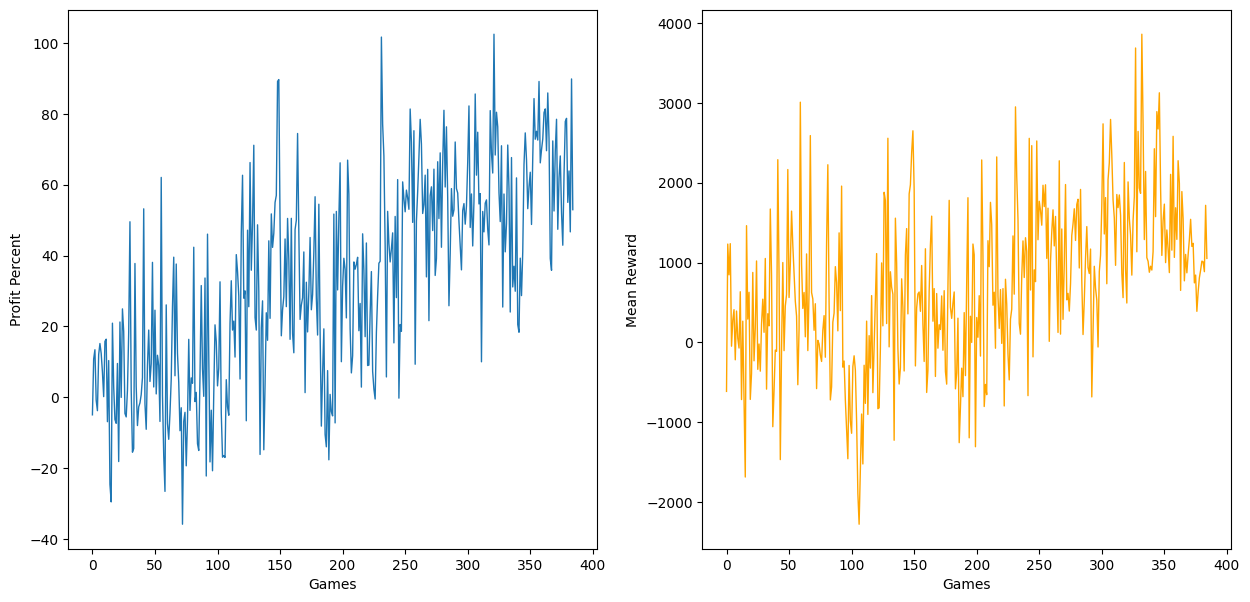

In [628]:
fig, ax=plt.subplots(1,2, figsize=(15,7))
ax[0].plot(np.array(plot_profit)*100,  linewidth=1) #profit as a percentage
ax[0].set(xlabel='Games', ylabel='Profit Percent')

ax[1].plot(plot_reward, linewidth=1, color='orange')
ax[1].set(xlabel='Games', ylabel='Mean Reward')

# ax[2].plot(plot_loss, linewidth=1, color='royalblue')
# ax[2].set(xlabel='Games', ylabel='Smooth L1 Loss')

## **Visualize Actions**, **Positive: BUY, Negative: SELL**

<ipython-input-644-110b9707ec2f>:16: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game330')

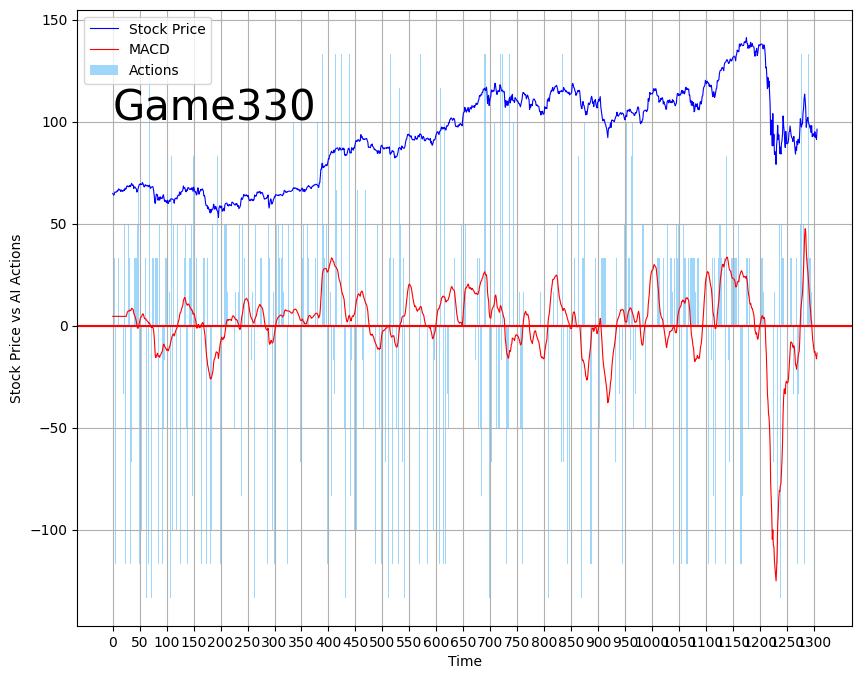

In [644]:
plt.figure(figsize=(10,8))
game_i=330 #input this to see actions in game i
game_length=stock_price_train.shape[0]-CONTEXT  #length of stock price
#visualize actions
plt.bar(x=np.arange(0,game_length), height=np.array(actions[game_length*game_i:game_length*(game_i+1)])/30, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_train, linewidth=0.8, color="blue", label='Stock Price')
plt.plot(stock_train[:,11]*10, linewidth=0.8, color="red", label='MACD')

plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_train.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)

### **Back Testing**

In [630]:
agent.n_games=5000
actions_test=[]
plot_profit_test=[]
plot_reward_test=[]
def test():
    rewards = []
    record = 0
    #create game on Testing set
    game = Game(w=CONTEXT, stock=stock_test, stock_price=stock_price_test, 
                 stock_delta=stock_delta_test, stock_pred_price=transformer_pred_test, pred_delta=pred_delta_test)
    epoch=6000 #a very large number just to keep the game running
    for i in tqdm( range(1,epoch+1) ):
        
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions_test.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)

        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward_test.append(mean_reward)
            rewards=[]
            game.reset()
            agent.n_games += 1
            if profit > record:
                record = profit

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon)

            plot_profit.append(profit)



In [631]:
test()

 13%|█▎        | 776/6000 [00:01<00:10, 486.81it/s]

Game 5001 mean Reward 1267.95 Profit 41.07 Record: 41.07 eps 10


 25%|██▌       | 1502/6000 [00:03<00:08, 557.19it/s]

Game 5002 mean Reward 332.52 Profit 37.37 Record: 41.07 eps 10


 37%|███▋      | 2191/6000 [00:04<00:06, 601.78it/s]

Game 5003 mean Reward 617.89 Profit 37.33 Record: 41.07 eps 10


 48%|████▊     | 2876/6000 [00:05<00:05, 616.57it/s]

Game 5004 mean Reward 1203.05 Profit 38.38 Record: 41.07 eps 10


 60%|█████▉    | 3582/6000 [00:06<00:03, 638.88it/s]

Game 5005 mean Reward 1464.26 Profit 44.92 Record: 44.92 eps 10


 71%|███████▏  | 4288/6000 [00:07<00:02, 611.03it/s]

Game 5006 mean Reward 939.61 Profit 44.77 Record: 44.92 eps 10


 82%|████████▏ | 4928/6000 [00:08<00:01, 617.99it/s]

Game 5007 mean Reward 1305.7 Profit 38.76 Record: 44.92 eps 10


 94%|█████████▍| 5640/6000 [00:09<00:00, 627.56it/s]

Game 5008 mean Reward 917.59 Profit 39.57 Record: 44.92 eps 10


100%|██████████| 6000/6000 [00:10<00:00, 582.21it/s]


<ipython-input-646-dd4771ac6e61>:14: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game3')

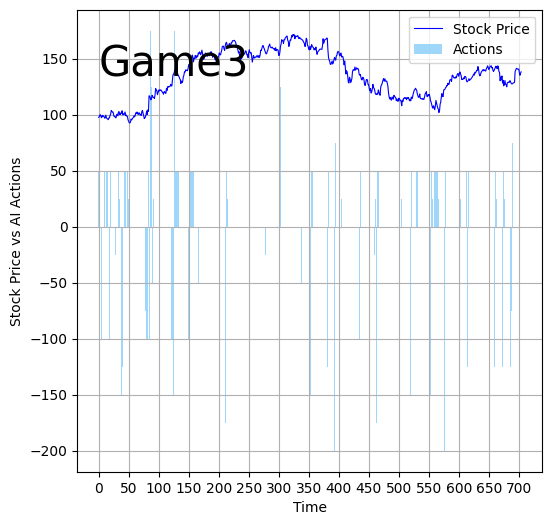

In [646]:
plt.figure(figsize=(6,6))
game_i=3 #input this to see actions in game i
game_length=stock_price_test.shape[0]-CONTEXT  #length of stock price
plt.bar(x=np.arange(0,game_length), height=np.array(actions_test[game_length*game_i:game_length*(game_i+1)])/20, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_test, linewidth=0.8, color="blue", label='Stock Price')

# plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_test.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)